In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy
from scipy.stats import skew
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tqdm import tqdm

def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    mean_intensity = np.mean(patch)
    entropy = shannon_entropy(patch)
    skewness = skew(patch.flatten())
    return {
        "Mean": round(mean_intensity, 2),
        "Contrast": round(contrast, 4),
        "Energy": round(energy, 4),
        "Entropy": round(entropy, 4),
        "Homogeneity": round(homogeneity, 4),
        "Skewness": round(skewness, 4)
    }

def extract_features_for_ml(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_", "w_"]
    categories = ["n_ovary", "b_v", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    white_features = []
    rgb_features = []
    white_labels = []
    rgb_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue

            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue

            basename = file.replace("w_", "")  # "001.png"
            rel_dir = os.path.relpath(subdir, root_folder)

            # Store temp RGB features
            rgb_feats_per_cat = defaultdict(dict)

            for img_prefix in image_types:
                fname = f"{img_prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue

                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]

                    feats = compute_texture_features(region_pixels)
                    if feats is None:
                        continue

                    if img_prefix == "w_":
                        white_features.append([
                            feats["Mean"], feats["Contrast"], feats["Energy"],
                            feats["Entropy"], feats["Homogeneity"], feats["Skewness"]
                        ])
                        white_labels.append(cat)
                    else:
                        rgb_feats_per_cat[cat][img_prefix] = feats

            # Merge r_, g_, b_ into one feature vector
            for cat in rgb_feats_per_cat:
                try:
                    f_r = rgb_feats_per_cat[cat]["r_"]
                    f_g = rgb_feats_per_cat[cat]["g_"]
                    f_b = rgb_feats_per_cat[cat]["b_"]
                    combined_feats = (
                        [f_r["Mean"], f_r["Contrast"], f_r["Energy"], f_r["Entropy"], f_r["Homogeneity"], f_r["Skewness"]] +
                        [f_g["Mean"], f_g["Contrast"], f_g["Energy"], f_g["Entropy"], f_g["Homogeneity"], f_g["Skewness"]] +
                        [f_b["Mean"], f_b["Contrast"], f_b["Energy"], f_b["Entropy"], f_b["Homogeneity"], f_b["Skewness"]]
                    )
                    rgb_features.append(combined_feats)
                    rgb_labels.append(cat)
                except KeyError:
                    continue  # If any of r/g/b missing, skip
    return white_features, white_labels, rgb_features, rgb_labels


# --- Main --- #
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\Granulosa_data_1\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"

    print("🔄 Extracting features...")
    X_white, y_white, X_rgb, y_rgb = extract_features_for_ml(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    print("🧠 Training SVM classifier...")

    # Encode labels
    le = LabelEncoder()
    y_white_enc = le.fit_transform(y_white)
    y_rgb_enc = le.transform(y_rgb)

    # Train/test split
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_white, y_white_enc):
    Xw_train = [X_white[i] for i in train_idx]
    Xw_test = [X_white[i] for i in test_idx]
    yw_train = [y_white_enc[i] for i in train_idx]
    yw_test = [y_white_enc[i] for i in test_idx]

    # Train SVM
    clf_w = SVC(kernel='rbf')
    clf_w.fit(Xw_train, yw_train)
    pred_w = clf_w.predict(Xw_test)

    clf_rgb = SVC(kernel='rbf')
    clf_rgb.fit(Xr_train, yr_train)
    pred_rgb = clf_rgb.predict(Xr_test)

    print("\n📊 White-Light Only Classification:")
    print(classification_report(yw_test, pred_w, target_names=le.classes_))

    print("\n📊 RGB Combined Classification:")
    print(classification_report(yr_test, pred_rgb, target_names=le.classes_))


🔄 Extracting features...
🧠 Training SVM classifier...

📊 White-Light Only Classification:
              precision    recall  f1-score   support

         b_v       0.00      0.00      0.00         5
        h_nc       0.00      0.00      0.00         4
     n_ovary       0.30      1.00      0.46         6
      tumour       0.00      0.00      0.00         5

    accuracy                           0.30        20
   macro avg       0.07      0.25      0.12        20
weighted avg       0.09      0.30      0.14        20


📊 RGB Combined Classification:
              precision    recall  f1-score   support

         b_v       0.00      0.00      0.00         7
        h_nc       0.00      0.00      0.00         5
     n_ovary       0.43      0.86      0.57         7
      tumour       0.00      0.00      0.00         1

    accuracy                           0.30        20
   macro avg       0.11      0.21      0.14        20
weighted avg       0.15      0.30      0.20        20



c:\Users\vipul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vipul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vipul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vipul\anaconda3\Lib\site-packag

🔄 Extracting features...
🧠 Training SVM classifier...
🔄 Extracting features...
🧠 Encoding labels...
🧠 Training XGBoost classifier...


c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:46:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:46:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 White-Light Only Classification:
              precision    recall  f1-score   support

         b_v       0.50      0.40      0.44         5
        h_nc       0.33      0.50      0.40         4
     n_ovary       0.40      0.33      0.36         6
      tumour       0.20      0.20      0.20         5

    accuracy                           0.35        20
   macro avg       0.36      0.36      0.35        20
weighted avg       0.36      0.35      0.35        20


📊 RGB Combined Classification:
              precision    recall  f1-score   support

         b_v       0.25      0.20      0.22         5
        h_nc       0.50      0.50      0.50         4
     n_ovary       0.29      0.33      0.31         6
      tumour       0.20      0.20      0.20         5

    accuracy                           0.30        20
   macro avg       0.31      0.31      0.31        20
weighted avg       0.30      0.30      0.30        20



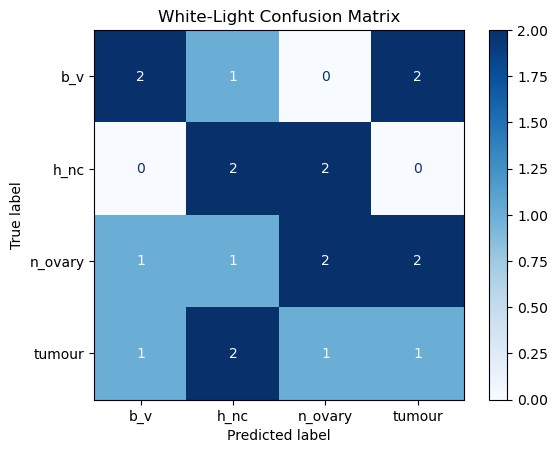

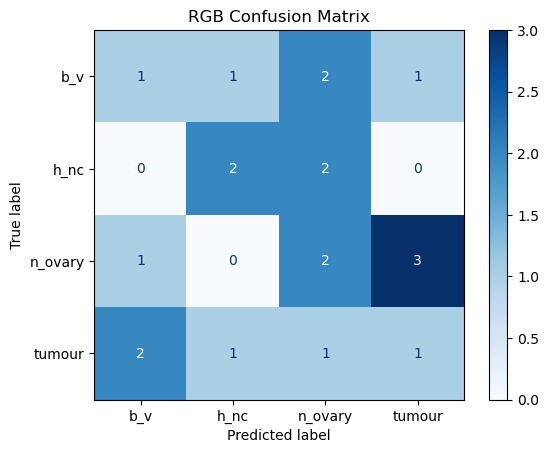

In [3]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy
from scipy.stats import skew
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tqdm import tqdm

def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    mean_intensity = np.mean(patch)
    entropy = shannon_entropy(patch)
    skewness = skew(patch.flatten())
    return {
        "Mean": round(mean_intensity, 2),
        "Contrast": round(contrast, 4),
        "Energy": round(energy, 4),
        "Entropy": round(entropy, 4),
        "Homogeneity": round(homogeneity, 4),
        "Skewness": round(skewness, 4)
    }

def extract_features_for_ml(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_", "w_"]
    categories = ["n_ovary", "b_v", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    white_features = []
    rgb_features = []
    white_labels = []
    rgb_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue

            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue

            basename = file.replace("w_", "")  # "001.png"
            rel_dir = os.path.relpath(subdir, root_folder)

            # Store temp RGB features
            rgb_feats_per_cat = defaultdict(dict)

            for img_prefix in image_types:
                fname = f"{img_prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue

                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]

                    feats = compute_texture_features(region_pixels)
                    if feats is None:
                        continue

                    if img_prefix == "w_":
                        white_features.append([
                            feats["Mean"], feats["Contrast"], feats["Energy"],
                            feats["Entropy"], feats["Homogeneity"], feats["Skewness"]
                        ])
                        white_labels.append(cat)
                    else:
                        rgb_feats_per_cat[cat][img_prefix] = feats

            # Merge r_, g_, b_ into one feature vector
            for cat in rgb_feats_per_cat:
                try:
                    f_r = rgb_feats_per_cat[cat]["r_"]
                    f_g = rgb_feats_per_cat[cat]["g_"]
                    f_b = rgb_feats_per_cat[cat]["b_"]
                    combined_feats = (
                        [f_r["Mean"], f_r["Contrast"], f_r["Energy"], f_r["Entropy"], f_r["Homogeneity"], f_r["Skewness"]] +
                        [f_g["Mean"], f_g["Contrast"], f_g["Energy"], f_g["Entropy"], f_g["Homogeneity"], f_g["Skewness"]] +
                        [f_b["Mean"], f_b["Contrast"], f_b["Energy"], f_b["Entropy"], f_b["Homogeneity"], f_b["Skewness"]]
                    )
                    rgb_features.append(combined_feats)
                    rgb_labels.append(cat)
                except KeyError:
                    continue  # If any of r/g/b missing, skip
    return white_features, white_labels, rgb_features, rgb_labels


# --- Main --- #
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\Granulosa_data_1\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"

    print("🔄 Extracting features...")
    X_white, y_white, X_rgb, y_rgb = extract_features_for_ml(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    print("🧠 Training SVM classifier...")

    # Encode labels
    le = LabelEncoder()
    y_white_enc = le.fit_transform(y_white)
    y_rgb_enc = le.transform(y_rgb)

    # Train/test split
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\Granulosa_data_1\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"

    print("🔄 Extracting features...")
    X_white, y_white, X_rgb, y_rgb = extract_features_for_ml(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    print("🧠 Encoding labels...")
    le = LabelEncoder()
    y_white_enc = le.fit_transform(y_white)
    y_rgb_enc = le.transform(y_rgb)

    print("🧠 Training XGBoost classifier...")

    # --- White Light Classification ---
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in sss.split(X_white, y_white_enc):
        Xw_train = [X_white[i] for i in train_idx]
        Xw_test = [X_white[i] for i in test_idx]
        yw_train = [y_white_enc[i] for i in train_idx]
        yw_test = [y_white_enc[i] for i in test_idx]

    clf_w = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    clf_w.fit(Xw_train, yw_train)
    pred_w = clf_w.predict(Xw_test)

    print("\n📊 White-Light Only Classification:")
    print(classification_report(yw_test, pred_w, target_names=le.classes_))

    # --- RGB Classification ---
    sss_rgb = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in sss_rgb.split(X_rgb, y_rgb_enc):
        Xr_train = [X_rgb[i] for i in train_idx]
        Xr_test = [X_rgb[i] for i in test_idx]
        yr_train = [y_rgb_enc[i] for i in train_idx]
        yr_test = [y_rgb_enc[i] for i in test_idx]

    clf_rgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    clf_rgb.fit(Xr_train, yr_train)
    pred_rgb = clf_rgb.predict(Xr_test)

    print("\n📊 RGB Combined Classification:")
    print(classification_report(yr_test, pred_rgb, target_names=le.classes_))
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(yw_test, pred_w, display_labels=le.classes_, cmap='Blues')
plt.title("White-Light Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(yr_test, pred_rgb, display_labels=le.classes_, cmap='Blues')
plt.title("RGB Confusion Matrix")
plt.show()


🔄 Extracting features...

🧠 Training XGBoost classifiers...


c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:06:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 White-Light Classification:
              precision    recall  f1-score   support

         b_v       0.50      0.40      0.44         5
        h_nc       1.00      1.00      1.00         4
     n_ovary       0.40      0.33      0.36         6
      tumour       0.57      0.80      0.67         5

    accuracy                           0.60        20
   macro avg       0.62      0.63      0.62        20
weighted avg       0.59      0.60      0.59        20


📊 RGB Classification:
              precision    recall  f1-score   support

         b_v       0.25      0.20      0.22         5
        h_nc       0.67      0.50      0.57         4
     n_ovary       0.50      0.67      0.57         6
      tumour       0.60      0.60      0.60         5

    accuracy                           0.50        20
   macro avg       0.50      0.49      0.49        20
weighted avg       0.50      0.50      0.49        20



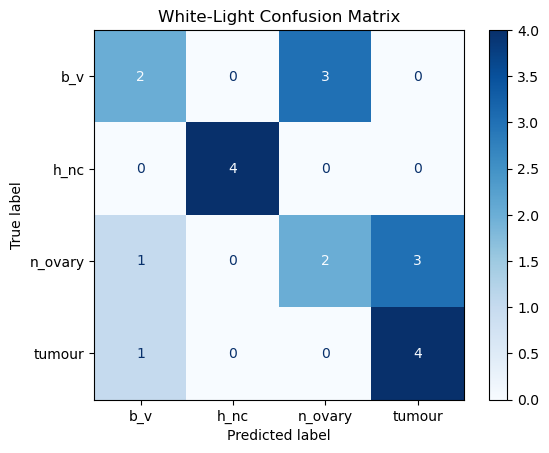

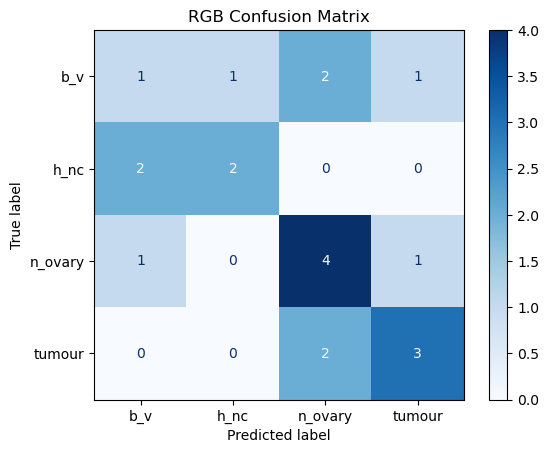

In [4]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy
from scipy.stats import skew
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch = gray
    if min(gray.shape) > 64:
        center = tuple(s // 2 for s in gray.shape)
        patch = gray[center[0]-32:center[0]+32, center[1]-32:center[1]+32]

    glcm = graycomatrix(patch, distances=[1, 2], angles=[0, np.pi/4], levels=256, symmetric=True, normed=True)
    contrast = np.mean(graycoprops(glcm, 'contrast'))
    energy = np.mean(graycoprops(glcm, 'energy'))
    homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))
    entropy = shannon_entropy(patch)
    skewness = skew(patch.flatten())
    std = np.std(patch)
    mean_intensity = np.mean(patch)

    return {
        "Mean": round(mean_intensity, 2),
        "Std": round(std, 2),
        "Contrast": round(contrast, 4),
        "Energy": round(energy, 4),
        "Entropy": round(entropy, 4),
        "Homogeneity": round(homogeneity, 4),
        "Skewness": round(skewness, 4)
    }

def extract_features_for_ml(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_", "w_"]
    categories = ["n_ovary", "b_v", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    white_features, rgb_features = [], []
    white_labels, rgb_labels = [], []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            rgb_feats_per_cat = defaultdict(dict)

            for img_prefix in image_types:
                fname = f"{img_prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    feats = compute_texture_features(region_pixels)
                    if feats is None:
                        continue
                    vec = [feats[k] for k in feats]
                    if img_prefix == "w_":
                        white_features.append(vec)
                        white_labels.append(cat)
                    else:
                        rgb_feats_per_cat[cat][img_prefix] = feats

            for cat in rgb_feats_per_cat:
                try:
                    f_r = rgb_feats_per_cat[cat]["r_"]
                    f_g = rgb_feats_per_cat[cat]["g_"]
                    f_b = rgb_feats_per_cat[cat]["b_"]
                    combined_feats = [f_r[k] for k in f_r] + [f_g[k] for k in f_g] + [f_b[k] for k in f_b]
                    rgb_features.append(combined_feats)
                    rgb_labels.append(cat)
                except KeyError:
                    continue

    return white_features, white_labels, rgb_features, rgb_labels

# -------------------- Main Training -------------------- #
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\\Granulosa_data_1\\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\\Granulosa_data_1\\vipul_annotation_1\\annotation_27_05_25_vipul_3.json"

    print("🔄 Extracting features...")
    X_white, y_white, X_rgb, y_rgb = extract_features_for_ml(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    le = LabelEncoder()
    y_white_enc = le.fit_transform(y_white)
    y_rgb_enc = le.transform(y_rgb)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in sss.split(X_white, y_white_enc):
        Xw_train = [X_white[i] for i in train_idx]
        Xw_test = [X_white[i] for i in test_idx]
        yw_train = [y_white_enc[i] for i in train_idx]
        yw_test = [y_white_enc[i] for i in test_idx]

    for train_idx, test_idx in sss.split(X_rgb, y_rgb_enc):
        Xr_train = [X_rgb[i] for i in train_idx]
        Xr_test = [X_rgb[i] for i in test_idx]
        yr_train = [y_rgb_enc[i] for i in train_idx]
        yr_test = [y_rgb_enc[i] for i in test_idx]

    # Normalize
    scaler_w = StandardScaler()
    Xw_train = scaler_w.fit_transform(Xw_train)
    Xw_test = scaler_w.transform(Xw_test)

    scaler_r = StandardScaler()
    Xr_train = scaler_r.fit_transform(Xr_train)
    Xr_test = scaler_r.transform(Xr_test)

    # Resample
    sm = SMOTE(random_state=42)
    Xw_train, yw_train = sm.fit_resample(Xw_train, yw_train)
    Xr_train, yr_train = sm.fit_resample(Xr_train, yr_train)

    print("\n🧠 Training XGBoost classifiers...")
    clf_w = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, subsample=0.9,
                          colsample_bytree=0.8, use_label_encoder=False, eval_metric='mlogloss')
    clf_w.fit(Xw_train, yw_train)
    pred_w = clf_w.predict(Xw_test)

    clf_rgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, subsample=0.9,
                            colsample_bytree=0.8, use_label_encoder=False, eval_metric='mlogloss')
    clf_rgb.fit(Xr_train, yr_train)
    pred_rgb = clf_rgb.predict(Xr_test)

    print("\n📊 White-Light Classification:")
    print(classification_report(yw_test, pred_w, target_names=le.classes_))

    print("\n📊 RGB Classification:")
    print(classification_report(yr_test, pred_rgb, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(yw_test, pred_w, display_labels=le.classes_, cmap='Blues')
    plt.title("White-Light Confusion Matrix")
    plt.show()

    ConfusionMatrixDisplay.from_predictions(yr_test, pred_rgb, display_labels=le.classes_, cmap='Blues')
    plt.title("RGB Confusion Matrix")
    plt.show()


LIGHT GBM

In [6]:
pip install lightgbm



   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 12.8 MB/s eta 0:00:00


In [7]:
pip install lightgbm scikit-learn imbalanced-learn matplotlib pillow


Note: you may need to restart the kernel to use updated packages.


🔍 Extracting RGB features...
📊 Encoding + Scaling + Oversampling...
🔢 After SMOTE: [33 33 33 33]
🧠 Training LightGBM with Repeated Stratified K-Fold...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 105, number of used features: 18
[LightGBM] [Info] Start training from score -1.395864
[LightGBM] [Info] Start training from score -1.395864
[LightGBM] [Info] Start training from score -1.395864
[LightGBM] [Info] Start training from score -1.358123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

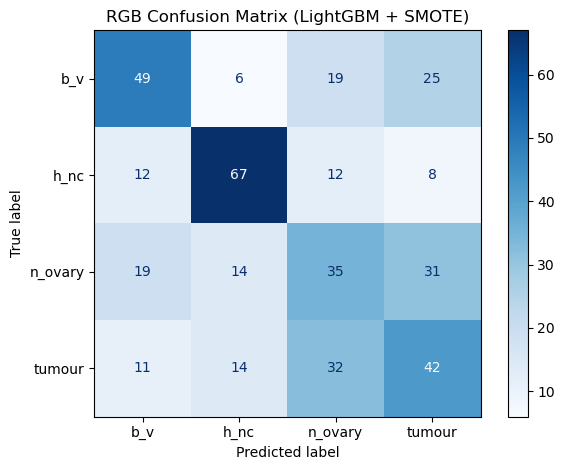

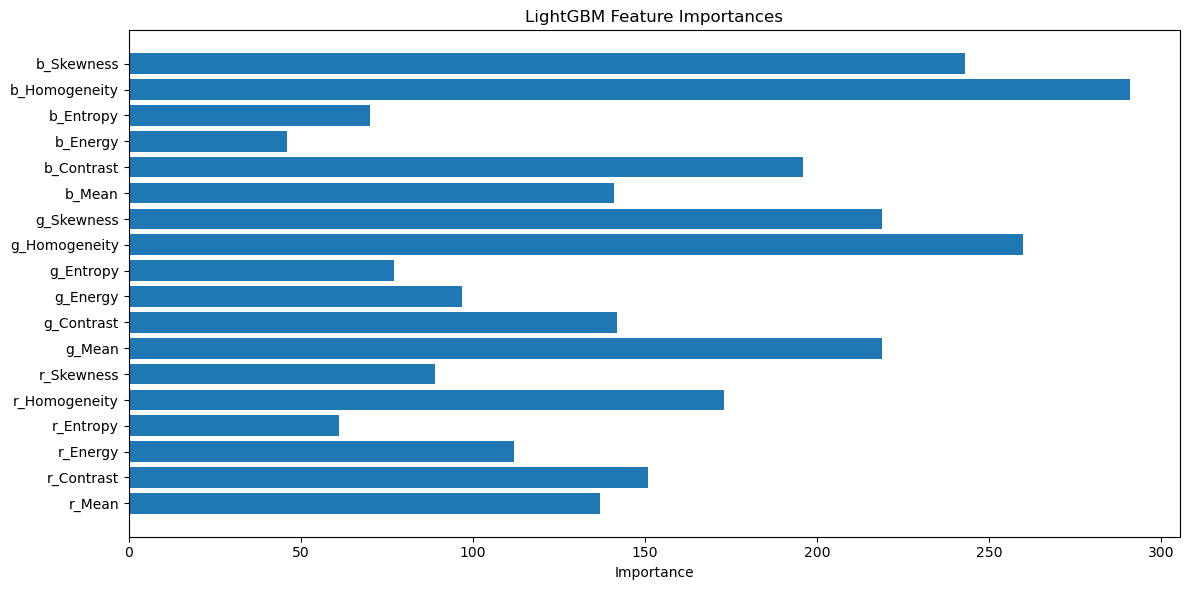

In [12]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy
from scipy.stats import skew
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Load and index COCO JSON annotations
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# 2. Generate binary mask per category
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

# 3. Texture feature extractor
def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    return {
        "Mean": np.mean(patch),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Entropy": shannon_entropy(patch),
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Skewness": skew(patch.flatten())
    }

# 4. Feature extraction from RGB images
def extract_rgb_features(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_"]
    categories = ["n_ovary", "b_v", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    rgb_features = []
    rgb_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            rgb_feats_per_cat = defaultdict(dict)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    feats = compute_texture_features(region_pixels)
                    if feats:
                        rgb_feats_per_cat[cat][prefix] = feats

            for cat in rgb_feats_per_cat:
                try:
                    f_r = rgb_feats_per_cat[cat]["r_"]
                    f_g = rgb_feats_per_cat[cat]["g_"]
                    f_b = rgb_feats_per_cat[cat]["b_"]
                    combined = (
                        [f_r["Mean"], f_r["Contrast"], f_r["Energy"], f_r["Entropy"], f_r["Homogeneity"], f_r["Skewness"]] +
                        [f_g["Mean"], f_g["Contrast"], f_g["Energy"], f_g["Entropy"], f_g["Homogeneity"], f_g["Skewness"]] +
                        [f_b["Mean"], f_b["Contrast"], f_b["Energy"], f_b["Entropy"], f_b["Homogeneity"], f_b["Skewness"]]
                    )
                    rgb_features.append(combined)
                    rgb_labels.append(cat)
                except KeyError:
                    continue

    return rgb_features, rgb_labels

# 5. Main training pipeline
def train_rgb_classifier(features, labels):
    print("📊 Encoding + Scaling + Oversampling...")
    le = LabelEncoder()
    y = le.fit_transform(labels)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print(f"🔢 After SMOTE: {np.bincount(y_resampled)}")

    print("🧠 Training LightGBM with Repeated Stratified K-Fold...")
    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    preds_all = []
    truths_all = []

    clf = LGBMClassifier(n_estimators=200, learning_rate=0.05)
    for fold, (train_idx, test_idx) in enumerate(rkf.split(X_resampled, y_resampled), 1):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

        preds_all.extend(preds)
        truths_all.extend(y_test)

    print("\n✅ Final Classification Report (RGB + SMOTE + LightGBM):")
    print(classification_report(truths_all, preds_all, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
    )
    plt.title("RGB Confusion Matrix (LightGBM + SMOTE)")
    plt.tight_layout()
    plt.show()

    return clf  # ✅ Return the trained classifier

# --- Entry Point --- #
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\Granulosa_data_1\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"

    print("🔍 Extracting RGB features...")
    X_rgb, y_rgb = extract_rgb_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if len(X_rgb) == 0:
        print("❌ No RGB features extracted.")
    else:
        clf = train_rgb_classifier(X_rgb, y_rgb)  # ✅ Capture the trained model

        # ✅ Plot feature importances
        importances = clf.feature_importances_
        feature_names = [
            "r_Mean", "r_Contrast", "r_Energy", "r_Entropy", "r_Homogeneity", "r_Skewness",
            "g_Mean", "g_Contrast", "g_Energy", "g_Entropy", "g_Homogeneity", "g_Skewness",
            "b_Mean", "b_Contrast", "b_Energy", "b_Entropy", "b_Homogeneity", "b_Skewness"
        ]
        plt.figure(figsize=(12, 6))
        plt.barh(feature_names, importances)
        plt.xlabel("Importance")
        plt.title("LightGBM Feature Importances")
        plt.tight_layout()
        plt.show()


#Random Forest

🔍 Extracting RGB features...
📊 RGB | Encoding + Scaling + SMOTE...
🔢 After SMOTE: [33 33 33 33]

✅ Final Classification Report (RGB - Random Forest):
              precision    recall  f1-score   support

         b_v       0.56      0.44      0.50        99
        h_nc       0.67      0.84      0.74        99
     n_ovary       0.42      0.36      0.39        99
      tumour       0.44      0.48      0.46        99

    accuracy                           0.53       396
   macro avg       0.52      0.53      0.52       396
weighted avg       0.52      0.53      0.52       396



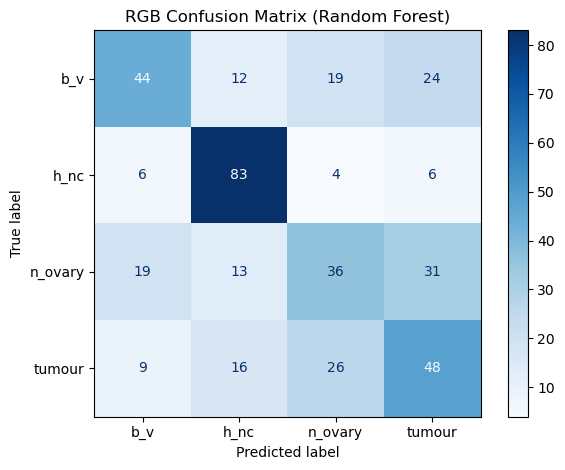

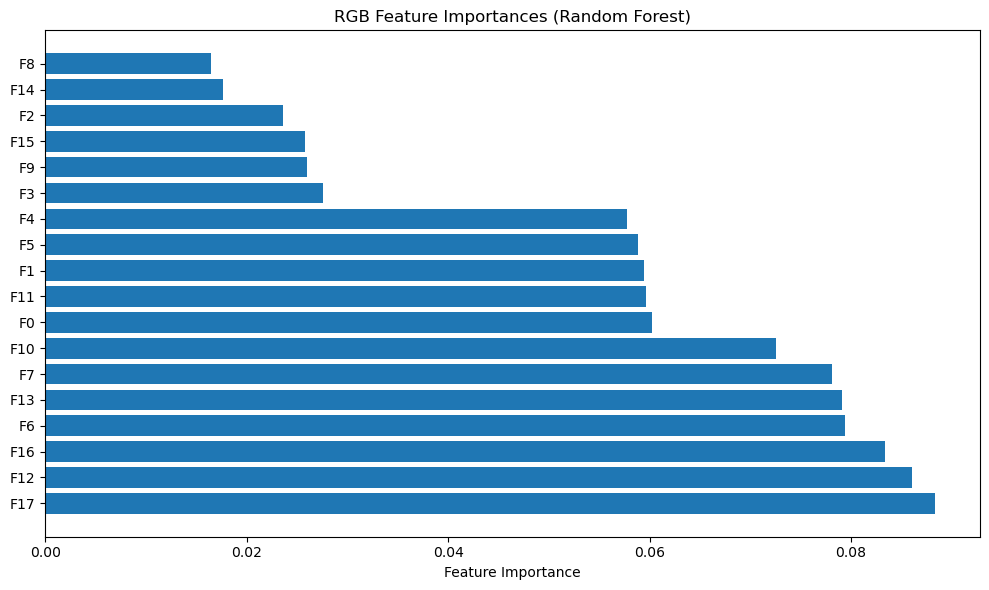

🔍 Extracting White Light features...
📊 White Light | Encoding + Scaling + SMOTE...
🔢 After SMOTE: [33 33 33 33]

✅ Final Classification Report (White Light - Random Forest):
              precision    recall  f1-score   support

         b_v       0.45      0.49      0.47        99
        h_nc       0.61      0.66      0.63        99
     n_ovary       0.40      0.31      0.35        99
      tumour       0.49      0.51      0.50        99

    accuracy                           0.49       396
   macro avg       0.49      0.49      0.49       396
weighted avg       0.49      0.49      0.49       396



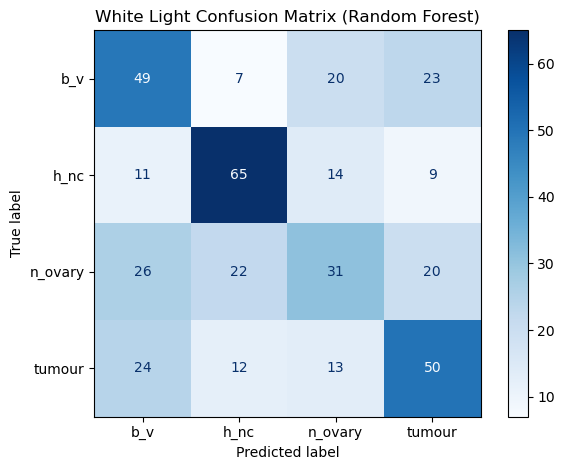

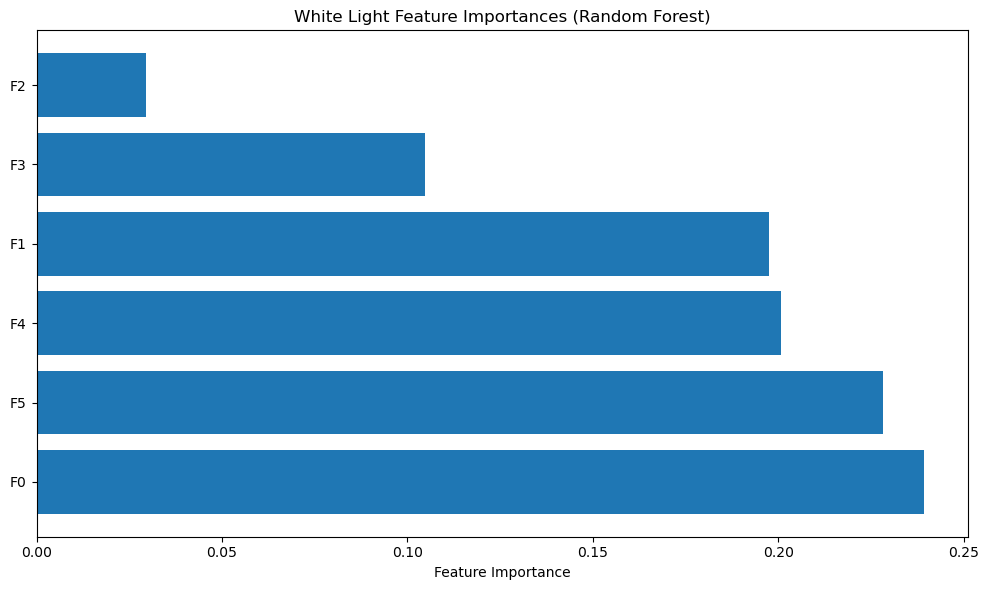

In [15]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy
from scipy.stats import skew
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------- COCO Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Mask & Feature Extraction -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    return {
        "Mean": np.mean(patch),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Entropy": shannon_entropy(patch),
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Skewness": skew(patch.flatten())
    }

# ------------------- Feature Extraction -------------------
def extract_rgb_features(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_"]
    categories = ["n_ovary", "b_v", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    rgb_features = []
    rgb_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            rgb_feats_per_cat = defaultdict(dict)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    feats = compute_texture_features(region_pixels)
                    if feats:
                        rgb_feats_per_cat[cat][prefix] = feats

            for cat in rgb_feats_per_cat:
                try:
                    f_r = rgb_feats_per_cat[cat]["r_"]
                    f_g = rgb_feats_per_cat[cat]["g_"]
                    f_b = rgb_feats_per_cat[cat]["b_"]
                    combined = (
                        [f_r["Mean"], f_r["Contrast"], f_r["Energy"], f_r["Entropy"], f_r["Homogeneity"], f_r["Skewness"]] +
                        [f_g["Mean"], f_g["Contrast"], f_g["Energy"], f_g["Entropy"], f_g["Homogeneity"], f_g["Skewness"]] +
                        [f_b["Mean"], f_b["Contrast"], f_b["Energy"], f_b["Entropy"], f_b["Homogeneity"], f_b["Skewness"]]
                    )
                    rgb_features.append(combined)
                    rgb_labels.append(cat)
                except KeyError:
                    continue

    return rgb_features, rgb_labels

# ------------------- Training Function -------------------
def train_with_random_forest(features, labels, title="RGB"):
    print(f"📊 {title} | Encoding + Scaling + SMOTE...")
    le = LabelEncoder()
    y = le.fit_transform(labels)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"🔢 After SMOTE: {np.bincount(y_resampled)}")

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    preds_all = []
    truths_all = []

    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        preds_all.extend(preds)
        truths_all.extend(y_test)

    print(f"\n✅ Final Classification Report ({title} - Random Forest):")
    print(classification_report(truths_all, preds_all, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"{title} Confusion Matrix (Random Forest)")
    plt.tight_layout()
    plt.show()

    # Feature importance plot
    plt.figure(figsize=(10, 6))
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = [f"F{i}" for i in range(X.shape[1])]
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title(f"{title} Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.show()

# ------------------- Entry Point -------------------
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\Granulosa_data_1\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"

    print("🔍 Extracting RGB features...")
    X_rgb, y_rgb = extract_rgb_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_rgb:
        print("❌ No features found for RGB.")
    else:
        train_with_random_forest(X_rgb, y_rgb, title="RGB")
# ------------------- White Light Feature Extraction -------------------
def extract_white_light_features(root_folder, coco_json_path):
    categories = ["n_ovary", "b_v", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    wl_features = []
    wl_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue

            img_path = os.path.join(subdir, file)
            img = Image.open(img_path).convert("RGB")
            img_np = np.array(img)

            for cat in categories:
                mask = create_category_mask(img.size, annotations, cat)
                if not np.any(mask):
                    continue
                region_pixels = img_np[mask == 1]
                if region_pixels.ndim == 1:
                    region_pixels = region_pixels[:, np.newaxis]
                feats = compute_texture_features(region_pixels)
                if feats:
                    feature_vector = [
                        feats["Mean"], feats["Contrast"], feats["Energy"],
                        feats["Entropy"], feats["Homogeneity"], feats["Skewness"]
                    ]
                    wl_features.append(feature_vector)
                    wl_labels.append(cat)

    return wl_features, wl_labels

# ------------------- Entry Point -------------------
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\Granulosa_data_1\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"

    print("🔍 Extracting White Light features...")
    X_wl, y_wl = extract_white_light_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_wl:
        print("❌ No features found for White Light.")
    else:
        train_with_random_forest(X_wl, y_wl, title="White Light")


🔍 Extracting RGB features...
📊 RGB | Encoding + Scaling + SMOTE...
🔢 After SMOTE: [27 27 27 27]

✅ Final Classification Report (RGB - Random Forest):
              precision    recall  f1-score   support

         b_v       0.46      0.44      0.45        81
        h_nc       0.66      0.78      0.71        81
     n_ovary       0.46      0.41      0.43        81
      tumour       0.49      0.47      0.48        81

    accuracy                           0.52       324
   macro avg       0.52      0.52      0.52       324
weighted avg       0.52      0.52      0.52       324



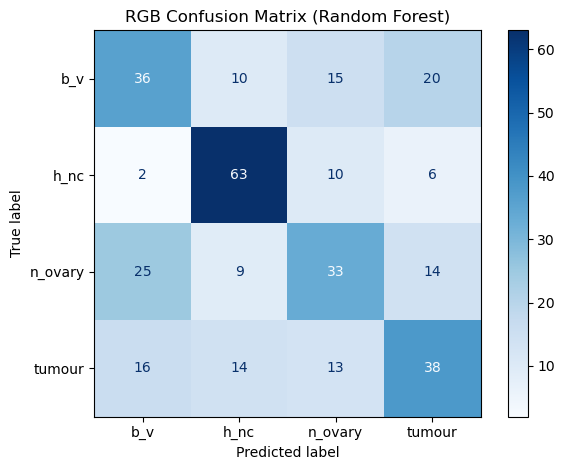

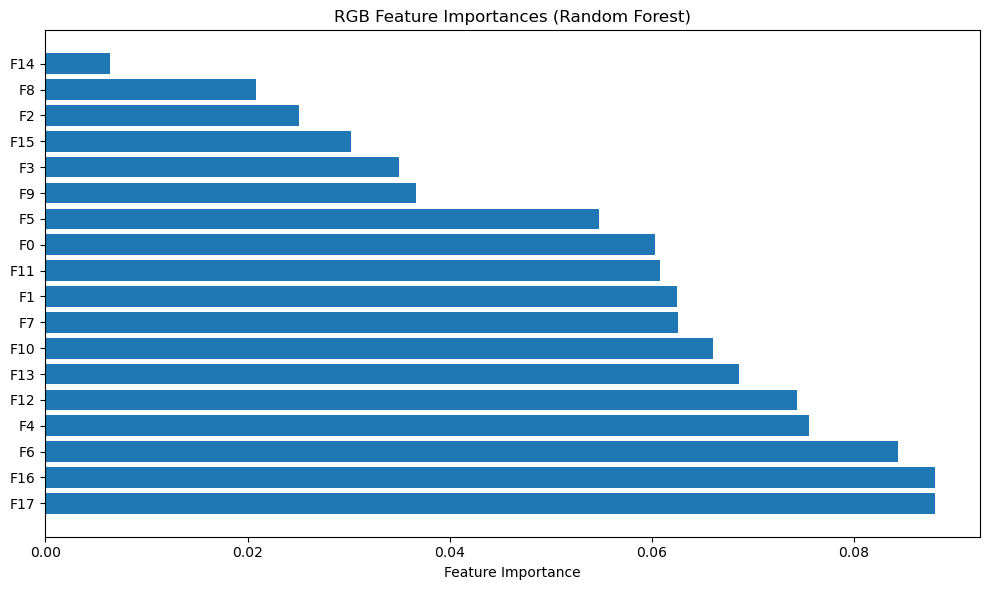

💾 Saved RGB model, label encoder, and scaler in 'models'

🔍 Extracting White Light features...
📊 White Light | Encoding + Scaling + SMOTE...
🔢 After SMOTE: [27 27 27 27]

✅ Final Classification Report (White Light - Random Forest):
              precision    recall  f1-score   support

         b_v       0.36      0.40      0.38        81
        h_nc       0.53      0.63      0.58        81
     n_ovary       0.37      0.33      0.35        81
      tumour       0.32      0.26      0.29        81

    accuracy                           0.40       324
   macro avg       0.39      0.40      0.40       324
weighted avg       0.39      0.40      0.40       324



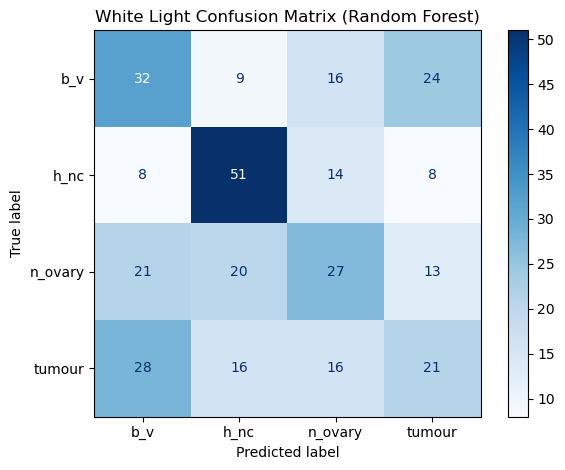

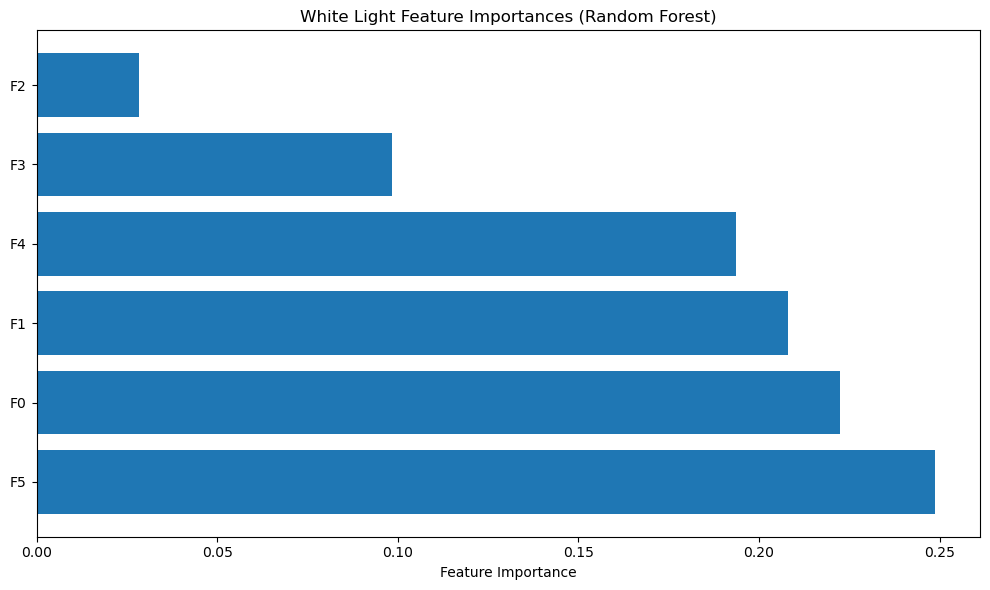

💾 Saved White Light model, label encoder, and scaler in 'models'


In [1]:
import os
import json
import numpy as np
import joblib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy
from scipy.stats import skew
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

# ------------------- COCO Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Mask & Feature Extraction -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    return {
        "Mean": np.mean(patch),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Entropy": shannon_entropy(patch),
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Skewness": skew(patch.flatten())
    }

# ------------------- RGB Feature Extraction -------------------
def extract_rgb_features(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_"]
    categories = ["n_ovary", "b_v", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    rgb_features = []
    rgb_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            rgb_feats_per_cat = defaultdict(dict)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    feats = compute_texture_features(region_pixels)
                    if feats:
                        rgb_feats_per_cat[cat][prefix] = feats

            for cat in rgb_feats_per_cat:
                try:
                    f_r = rgb_feats_per_cat[cat]["r_"]
                    f_g = rgb_feats_per_cat[cat]["g_"]
                    f_b = rgb_feats_per_cat[cat]["b_"]
                    combined = (
                        [f_r["Mean"], f_r["Contrast"], f_r["Energy"], f_r["Entropy"], f_r["Homogeneity"], f_r["Skewness"]] +
                        [f_g["Mean"], f_g["Contrast"], f_g["Energy"], f_g["Entropy"], f_g["Homogeneity"], f_g["Skewness"]] +
                        [f_b["Mean"], f_b["Contrast"], f_b["Energy"], f_b["Entropy"], f_b["Homogeneity"], f_b["Skewness"]]
                    )
                    rgb_features.append(combined)
                    rgb_labels.append(cat)
                except KeyError:
                    continue

    return rgb_features, rgb_labels

# ------------------- White Light Feature Extraction -------------------
def extract_white_light_features(root_folder, coco_json_path):
    categories = ["n_ovary", "b_v", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    wl_features = []
    wl_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue

            img_path = os.path.join(subdir, file)
            img = Image.open(img_path).convert("RGB")
            img_np = np.array(img)

            for cat in categories:
                mask = create_category_mask(img.size, annotations, cat)
                if not np.any(mask):
                    continue
                region_pixels = img_np[mask == 1]
                if region_pixels.ndim == 1:
                    region_pixels = region_pixels[:, np.newaxis]
                feats = compute_texture_features(region_pixels)
                if feats:
                    feature_vector = [
                        feats["Mean"], feats["Contrast"], feats["Energy"],
                        feats["Entropy"], feats["Homogeneity"], feats["Skewness"]
                    ]
                    wl_features.append(feature_vector)
                    wl_labels.append(cat)

    return wl_features, wl_labels

# ------------------- Train and Save Model -------------------
def train_with_random_forest(features, labels, title="RGB", save_model=False, model_dir="models"):
    print(f"📊 {title} | Encoding + Scaling + SMOTE...")
    le = LabelEncoder()
    y = le.fit_transform(labels)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"🔢 After SMOTE: {np.bincount(y_resampled)}")

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    preds_all = []
    truths_all = []

    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        preds_all.extend(preds)
        truths_all.extend(y_test)

    print(f"\n✅ Final Classification Report ({title} - Random Forest):")
    print(classification_report(truths_all, preds_all, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"{title} Confusion Matrix (Random Forest)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = [f"F{i}" for i in range(X.shape[1])]
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title(f"{title} Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.show()

    if save_model:
        os.makedirs(model_dir, exist_ok=True)
        prefix = title.lower().replace(" ", "_")
        joblib.dump(clf, os.path.join(model_dir, f"{prefix}_rf_model.pkl"))
        joblib.dump(le, os.path.join(model_dir, f"{prefix}_label_encoder.pkl"))
        joblib.dump(scaler, os.path.join(model_dir, f"{prefix}_scaler.pkl"))
        print(f"💾 Saved {title} model, label encoder, and scaler in '{model_dir}'")

# ------------------- Main Execution -------------------
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"

    print("🔍 Extracting RGB features...")
    X_rgb, y_rgb = extract_rgb_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)
    if not X_rgb:
        print("❌ No features found for RGB.")
    else:
        train_with_random_forest(X_rgb, y_rgb, title="RGB", save_model=True)

    print("\n🔍 Extracting White Light features...")
    X_wl, y_wl = extract_white_light_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)
    if not X_wl:
        print("❌ No features found for White Light.")
    else:
        train_with_random_forest(X_wl, y_wl, title="White Light", save_model=True)


🔍 Loading model files for RGB...
📦 Extracting features for RGB validation...

✅ Validation Report for RGB:
              precision    recall  f1-score   support

         b_v       0.00      0.00      0.00         1
        h_nc       0.62      0.71      0.67         7
     n_ovary       0.25      0.17      0.20         6
      tumour       0.00      0.00      0.00         3

    accuracy                           0.35        17
   macro avg       0.22      0.22      0.22        17
weighted avg       0.35      0.35      0.35        17



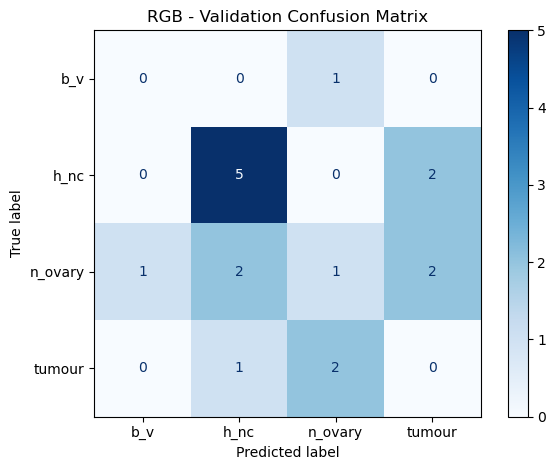

🔍 Loading model files for White Light...
📦 Extracting features for White Light validation...

✅ Validation Report for White Light:
              precision    recall  f1-score   support

         b_v       0.00      0.00      0.00         1
        h_nc       0.60      0.43      0.50         7
     n_ovary       0.75      0.50      0.60         6
      tumour       0.50      0.67      0.57         3

    accuracy                           0.47        17
   macro avg       0.46      0.40      0.42        17
weighted avg       0.60      0.47      0.52        17



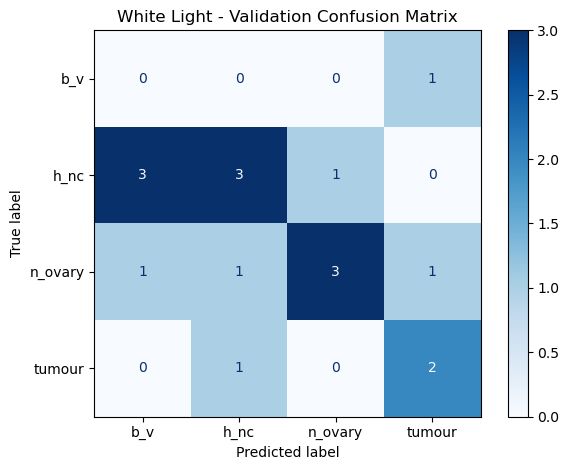

In [3]:
import os
import joblib
import numpy as np
from PIL import Image, ImageDraw
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy
from scipy.stats import skew
from collections import defaultdict
import json

# ------------------- Utility Functions -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    return [
        np.mean(patch),
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        shannon_entropy(patch),
        graycoprops(glcm, 'homogeneity')[0, 0],
        skew(patch.flatten())
    ]

# ------------------- Feature Extraction -------------------
def extract_features_for_validation(root_folder, coco_json_path, mode="RGB"):
    categories = ["n_ovary", "b_v", "h_nc", "tumour"]
    image_types = ["r_", "g_", "b_"] if mode == "RGB" else []
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    features = []
    labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")

            if mode == "RGB":
                rgb_feats_per_cat = defaultdict(dict)
                for prefix in image_types:
                    fname = f"{prefix}{basename}"
                    img_path = os.path.join(subdir, fname)
                    if not os.path.exists(img_path):
                        continue
                    img = Image.open(img_path).convert("RGB")
                    img_np = np.array(img)
                    for cat in categories:
                        mask = create_category_mask(img.size, annotations, cat)
                        if not np.any(mask):
                            continue
                        region_pixels = img_np[mask == 1]
                        if region_pixels.ndim == 1:
                            region_pixels = region_pixels[:, np.newaxis]
                        feats = compute_texture_features(region_pixels)
                        if feats:
                            rgb_feats_per_cat[cat][prefix] = feats

                for cat in rgb_feats_per_cat:
                    try:
                        f_r = rgb_feats_per_cat[cat]["r_"]
                        f_g = rgb_feats_per_cat[cat]["g_"]
                        f_b = rgb_feats_per_cat[cat]["b_"]
                        combined = f_r + f_g + f_b
                        features.append(combined)
                        labels.append(cat)
                    except KeyError:
                        continue

            else:  # White Light
                img_path = os.path.join(subdir, file)
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)
                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    feats = compute_texture_features(region_pixels)
                    if feats:
                        features.append(feats)
                        labels.append(cat)

    return features, labels

# ------------------- Model Validation -------------------
def validate_model(model_dir, root_folder, coco_json_path, mode="RGB"):
    prefix = mode.lower().replace(" ", "_")
    model_path = os.path.join(model_dir, f"{prefix}_rf_model.pkl")
    encoder_path = os.path.join(model_dir, f"{prefix}_label_encoder.pkl")
    scaler_path = os.path.join(model_dir, f"{prefix}_scaler.pkl")

    print(f"🔍 Loading model files for {mode}...")
    model = joblib.load(model_path)
    encoder = joblib.load(encoder_path)
    scaler = joblib.load(scaler_path)

    print(f"📦 Extracting features for {mode} validation...")
    X_val, y_val = extract_features_for_validation(root_folder, coco_json_path, mode=mode)
    if not X_val:
        print(f"❌ No validation features found for {mode}.")
        return

    X_val_scaled = scaler.transform(X_val)
    y_true = encoder.transform(y_val)
    y_pred = model.predict(X_val_scaled)

    print(f"\n✅ Validation Report for {mode}:")
    print(classification_report(y_true, y_pred, target_names=encoder.classes_))

    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=encoder.classes_, cmap='Blues'
    )
    plt.title(f"{mode} - Validation Confusion Matrix")
    plt.tight_layout()
    plt.show()

# ------------------- Run Validation -------------------
if __name__ == "__main__":
    MODEL_DIR = "models"
    VALIDATION_ROOT = r"H:\ML_MSI\ROI_based\val_data"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"

    # Validate RGB
    validate_model(MODEL_DIR, VALIDATION_ROOT, COCO_JSON_PATH, mode="RGB")

    # Validate White Light
    validate_model(MODEL_DIR, VALIDATION_ROOT, COCO_JSON_PATH, mode="White Light")


# Combined feature RGB+W

🔍 Extracting unified RGBW features...
📊 Multichannel RGBW | Encoding + Scaling + SMOTE...
🔢 After SMOTE: [33 33 33]

✅ Final Classification Report (Multichannel RGBW - Random Forest):
              precision    recall  f1-score   support

        h_nc       0.87      0.84      0.86        99
     n_ovary       0.83      0.75      0.79        99
      tumour       0.79      0.90      0.84        99

    accuracy                           0.83       297
   macro avg       0.83      0.83      0.83       297
weighted avg       0.83      0.83      0.83       297



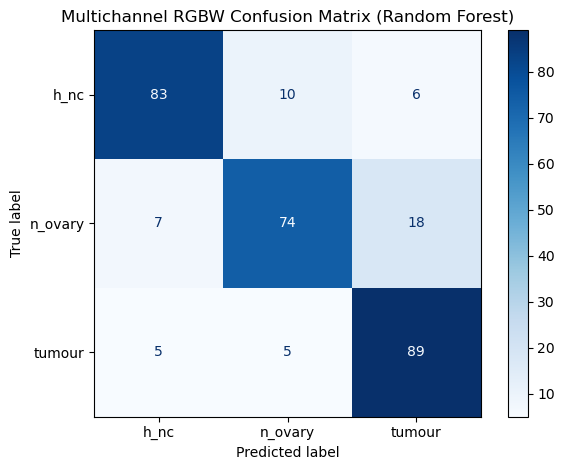

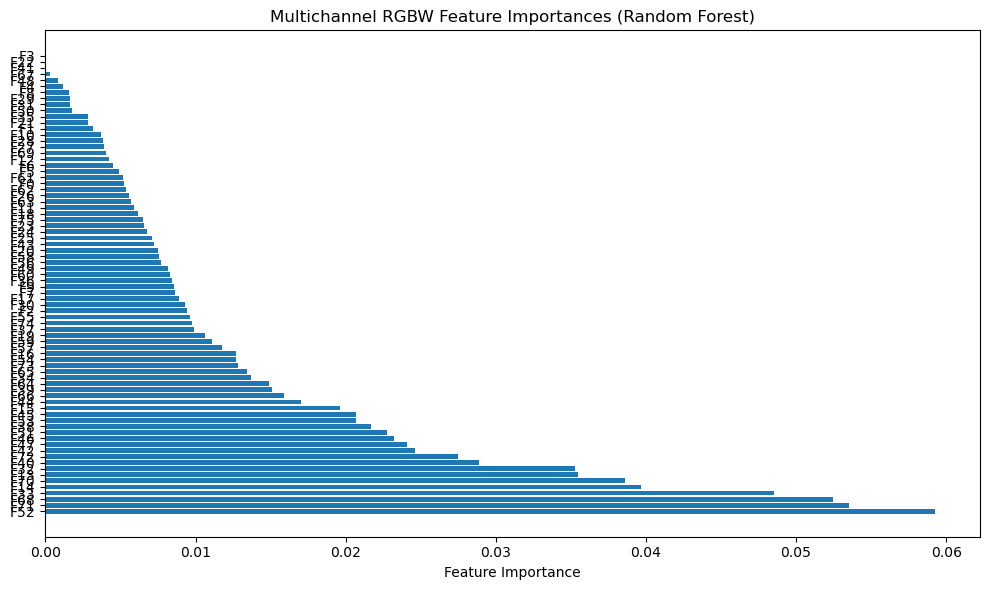

In [27]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Feature Aggregation -------------------
def extract_combined_features(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_", "w_"]
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape per image type
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

# ------------------- Classifier -------------------
def train_with_random_forest(features, labels, title="Multichannel RGBW"):
    print(f"📊 {title} | Encoding + Scaling + SMOTE...")
    le = LabelEncoder()
    y = le.fit_transform(labels)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"🔢 After SMOTE: {np.bincount(y_resampled)}")

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    preds_all = []
    truths_all = []

    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        preds_all.extend(preds)
        truths_all.extend(y_test)

    print(f"\n✅ Final Classification Report ({title} - Random Forest):")
    print(classification_report(truths_all, preds_all, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"{title} Confusion Matrix (Random Forest)")
    plt.tight_layout()
    plt.show()

    # Feature importance plot
    plt.figure(figsize=(10, 6))
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = [f"F{i}" for i in range(X.shape[1])]
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title(f"{title} Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.show()

# ------------------- Entry Point -------------------
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\Granulosa_data_1\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"

    print("🔍 Extracting unified RGBW features...")
    X_all, y_all = extract_combined_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_all:
        print("❌ No features found for RGBW.")
    else:
        train_with_random_forest(X_all, y_all, title="Multichannel RGBW")


Save the model

In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Feature Aggregation -------------------
def extract_combined_features(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_", "w_"]
    categories = ["n_ovary", "b_v", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape per image type
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

# ------------------- Classifier -------------------
def train_with_random_forest(features, labels, title="RGBW"):
    print(f"📊 {title} | Encoding + Scaling + SMOTE...")
    le = LabelEncoder()
    y = le.fit_transform(labels)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"🔢 After SMOTE: {np.bincount(y_resampled)}")

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    preds_all = []
    truths_all = []

    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        preds_all.extend(preds)
        truths_all.extend(y_test)

    print(f"\n✅ Final Classification Report ({title} - Random Forest):")
    print(classification_report(truths_all, preds_all, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"{title} Confusion Matrix (Random Forest)")
    plt.tight_layout()
    plt.show()

    # Feature importance plot
    plt.figure(figsize=(10, 6))
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = [f"F{i}" for i in range(X.shape[1])]
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title(f"{title} Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.show()

    # ✅ Save model, label encoder, and scaler
    import joblib
    import os
    os.makedirs("saved_model", exist_ok=True)
    joblib.dump(clf, "saved_model/random_forest_rgbw.pkl")
    joblib.dump(le, "saved_model/label_encoder.pkl")
    joblib.dump(scaler, "saved_model/scaler.pkl")
    print("✅ Model, Label Encoder, and Scaler saved in 'saved_model/' folder.")


SVM for RGBW

🔍 Extracting unified RGBW features...

📊 Multichannel RGBW - SVM | Encoding + Scaling + SMOTE...
🔢 After SMOTE: [27 27 27]

✅ Final Classification Report (Multichannel RGBW - SVM):
              precision    recall  f1-score   support

        h_nc       0.76      0.84      0.80        81
     n_ovary       0.67      0.57      0.61        81
      tumour       0.76      0.80      0.78        81

    accuracy                           0.74       243
   macro avg       0.73      0.74      0.73       243
weighted avg       0.73      0.74      0.73       243



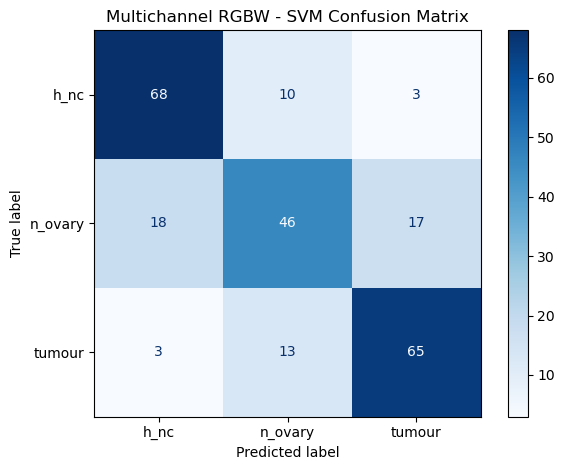

💾 Model, scaler, and label encoder saved in: H:\Granulosa_data_1\vipul_annotation_1\SVM_model


In [18]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # <-- Make sure this is properly aligned
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm


# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Feature Aggregation -------------------
def extract_combined_features(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_", "w_"]
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape per image type
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

# ------------------- Classifier -------------------
def train_with_random_forest(features, labels, title="Multichannel RGBW"):
    print(f"📊 {title} | Encoding + Scaling + SMOTE...")
    le = LabelEncoder()
    y = le.fit_transform(labels)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)


import joblib  # <-- Add at top if not already

def train_with_svm(features, labels, title="Multichannel RGBW - SVM", save_dir=None):
    print(f"\n📊 {title} | Encoding + Scaling + SMOTE...")
    le = LabelEncoder()
    y = le.fit_transform(labels)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"🔢 After SMOTE: {np.bincount(y_resampled)}")

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    preds_all = []
    truths_all = []

    clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)

    for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        preds_all.extend(preds)
        truths_all.extend(y_test)

    print(f"\n✅ Final Classification Report ({title}):")
    print(classification_report(truths_all, preds_all, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"{title} Confusion Matrix")
    plt.tight_layout()
    plt.show()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        joblib.dump(clf, os.path.join(save_dir, "svm_model.pkl"))
        joblib.dump(scaler, os.path.join(save_dir, "scaler.pkl"))
        joblib.dump(le, os.path.join(save_dir, "label_encoder.pkl"))
        print(f"💾 Model, scaler, and label encoder saved in: {save_dir}")



if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"
    SVM_MODEL_DIR = r"H:\Granulosa_data_1\vipul_annotation_1\SVM_model"  # <-- Where to save SVM model

    print("🔍 Extracting unified RGBW features...")
    X_all, y_all = extract_combined_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_all:
        print("❌ No features found for RGBW.")
    else:
        train_with_svm(X_all, y_all, title="Multichannel RGBW - SVM", save_dir=SVM_MODEL_DIR)


# SVM validation


🔍 Extracting validation features for mode: RGBW...
📊 RGBW | Validating on 16 regions...

✅ Classification Report on Validation Set:
              precision    recall  f1-score   support

        h_nc       1.00      1.00      1.00         7
     n_ovary       1.00      0.83      0.91         6
      tumour       0.75      1.00      0.86         3

    accuracy                           0.94        16
   macro avg       0.92      0.94      0.92        16
weighted avg       0.95      0.94      0.94        16



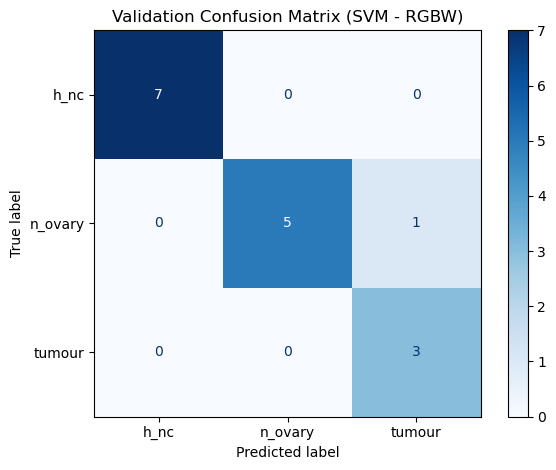

In [19]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Validation for SVM -------------------
def validate_svm_model_with_subfolders(image_root, json_path, model_dir, mode="RGBW"):
    print(f"\n🔍 Extracting validation features for mode: {mode}...")

    all_modes = {
        "RGBW": ["r_", "g_", "b_", "w_"],
        "RGB": ["r_", "g_", "b_"],
        "W": ["w_"]
    }
    image_types = all_modes[mode]
    categories = ["n_ovary", "h_nc", "tumour"]

    coco_data = load_coco_json(json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(image_root):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape per channel
                    all_features.append(feat_list)
                    all_labels.append(cat)

    if not all_features:
        print(f"❌ No features found in test set.")
        return

    print(f"📊 {mode} | Validating on {len(all_features)} regions...")

    # Load model, scaler, and label encoder
    clf = joblib.load(os.path.join(model_dir, "svm_model.pkl"))
    scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))
    le = joblib.load(os.path.join(model_dir, "label_encoder.pkl"))

    # Preprocess features
    X = scaler.transform(all_features)
    y_true = le.transform(all_labels)

    # Predict
    y_pred = clf.predict(X)

    # Report results
    print("\n✅ Classification Report on Validation Set:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"Validation Confusion Matrix (SVM - {mode})")
    plt.tight_layout()
    plt.show()

# ------------------- Entry Point -------------------
if __name__ == "__main__":
    TEST_FOLDER = r"H:\ML_MSI\ROI_based\val_data"
    TEST_JSON = r"H:\ML_MSI\ROI_based\val_data\annotation_27_05_25_vipul_3.json"
    MODEL_DIR = r"H:\ML_MSI\ROI_based\SVM_model"  # Ensure this folder contains svm_model.pkl etc.

    validate_svm_model_with_subfolders(TEST_FOLDER, TEST_JSON, MODEL_DIR, mode="RGBW")


XGBoost for RGBW

In [23]:
pip install xgboost


In [24]:
from xgboost import XGBClassifier


🔍 Extracting unified RGBW features...
📊 Multichannel RGBW | Encoding + Scaling + SMOTE...
🔢 After SMOTE: [27 27 27]


c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:30:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:30:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:30:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:30:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr


✅ Final Classification Report (Multichannel RGBW - XGBoost):
              precision    recall  f1-score   support

        h_nc       0.77      0.74      0.75        81
     n_ovary       0.64      0.57      0.60        81
      tumour       0.75      0.86      0.80        81

    accuracy                           0.72       243
   macro avg       0.72      0.72      0.72       243
weighted avg       0.72      0.72      0.72       243



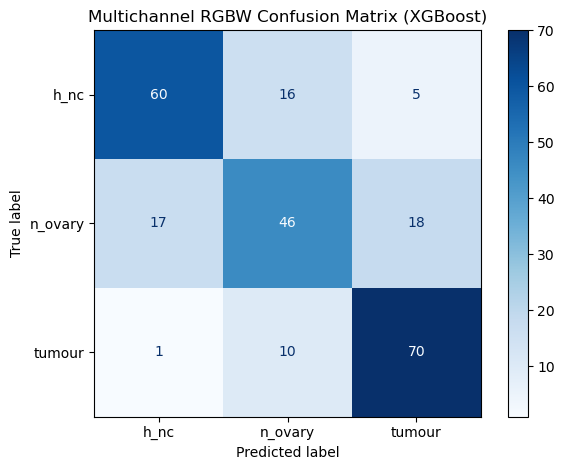

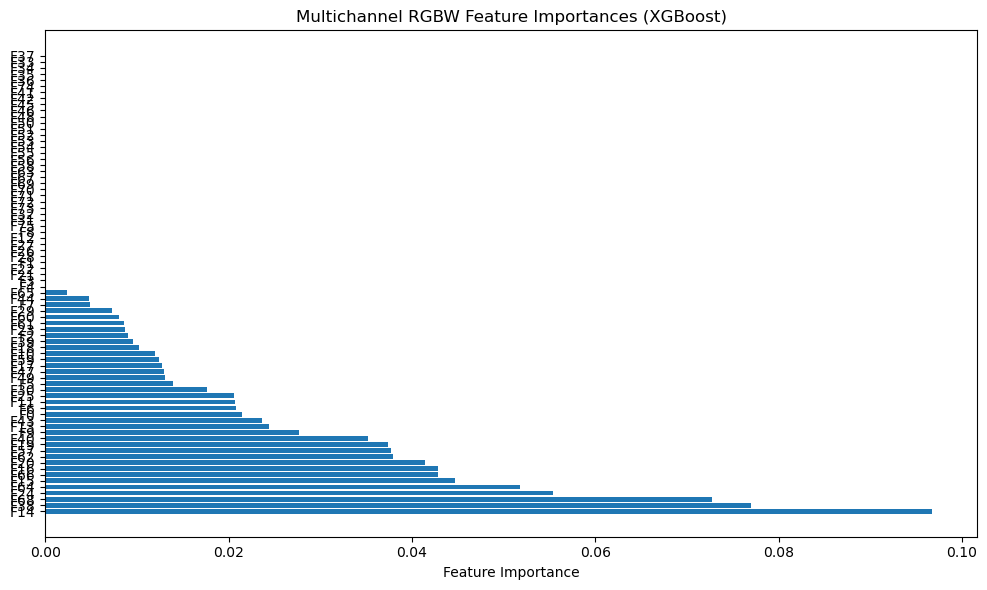


💾 Model, scaler, and label encoder saved to: H:\\ML_MSI\\ROI_based\\XGB_model


In [16]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # <-- Make sure this is properly aligned
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm


# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Feature Aggregation -------------------
def extract_combined_features(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_", "w_"]
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape per image type
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

from xgboost import XGBClassifier
import joblib  # <-- Add this import at the top

def train_with_xgboost(features, labels, title="Multichannel RGBW", model_save_dir="xgboost_model"):
    print(f"📊 {title} | Encoding + Scaling + SMOTE...")

    le = LabelEncoder()
    y = le.fit_transform(labels)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"🔢 After SMOTE: {np.bincount(y_resampled)}")

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    preds_all, truths_all = [], []

    clf = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3,
                        random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    
    for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        preds_all.extend(preds)
        truths_all.extend(y_test)

    print(f"\n✅ Final Classification Report ({title} - XGBoost):")
    print(classification_report(truths_all, preds_all, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"{title} Confusion Matrix (XGBoost)")
    plt.tight_layout()
    plt.show()

    # Feature importance plot
    plt.figure(figsize=(10, 6))
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = [f"F{i}" for i in range(X.shape[1])]
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title(f"{title} Feature Importances (XGBoost)")
    plt.tight_layout()
    plt.show()

    # 🔒 Save model, scaler, and label encoder
    os.makedirs(model_save_dir, exist_ok=True)
    joblib.dump(clf, os.path.join(model_save_dir, "xgboost_model.pkl"))
    joblib.dump(scaler, os.path.join(model_save_dir, "scaler.pkl"))
    joblib.dump(le, os.path.join(model_save_dir, "label_encoder.pkl"))
    print(f"\n💾 Model, scaler, and label encoder saved to: {model_save_dir}")


if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\\Granulosa_data_1\\vipul_annotation_1\\annotation_27_05_25_vipul_3.json"
    MODEL_SAVE_DIR = r"H:\\ML_MSI\\ROI_based\\XGB_model"

    print("🔍 Extracting unified RGBW features...")
    X_all, y_all = extract_combined_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_all:
        print("❌ No features found for RGBW.")
    else:
        train_with_xgboost(X_all, y_all, title="Multichannel RGBW", model_save_dir=MODEL_SAVE_DIR)


# validation XGBoost Model

🔍 Extracting validation features...
✅ Validation Classification Report:
              precision    recall  f1-score   support

        h_nc       0.71      0.71      0.71         7
     n_ovary       0.60      0.50      0.55         6
      tumour       0.50      0.67      0.57         3

    accuracy                           0.62        16
   macro avg       0.60      0.63      0.61        16
weighted avg       0.63      0.62      0.62        16



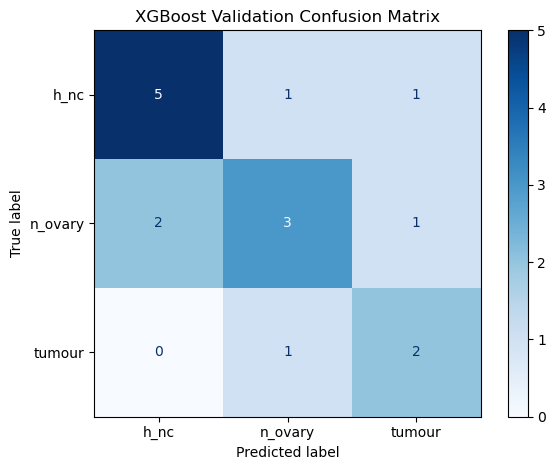

In [17]:
import os
import json
import numpy as np
import joblib
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------- JSON Helpers -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extraction -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

def extract_combined_features(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_", "w_"]
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

# ------------------- Load + Validate -------------------
def load_assets(model_dir):
    clf = joblib.load(os.path.join(model_dir, "xgboost_model.pkl"))
    scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))
    label_encoder = joblib.load(os.path.join(model_dir, "label_encoder.pkl"))
    return clf, scaler, label_encoder

def validate_xgboost_model(X_val, y_val, model_dir):
    clf, scaler, label_encoder = load_assets(model_dir)
    y_true = label_encoder.transform(y_val)
    X_scaled = scaler.transform(X_val)

    y_pred = clf.predict(X_scaled)

    print("✅ Validation Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=label_encoder.classes_, cmap='Blues'
    )
    plt.title("XGBoost Validation Confusion Matrix")
    plt.tight_layout()
    plt.show()

# ------------------- Main -------------------
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\val_data"
    COCO_JSON_PATH = r"H:\ML_MSI\ROI_based\val_data\annotation_27_05_25_vipul_3.json"
    MODEL_DIR = r"H:\ML_MSI\ROI_based\XGB_model"

    print("🔍 Extracting validation features...")
    X_val, y_val = extract_combined_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_val:
        print("❌ No features extracted.")
    else:
        validate_xgboost_model(X_val, y_val, model_dir=MODEL_DIR)


#Random_forest


🔍 Extracting features for mode: RGBW...
📊 Mode: RGBW | Encoding + Scaling + SMOTE...
🔢 After SMOTE: [27 27 27]

✅ Final Classification Report (Mode: RGBW - Random Forest):
              precision    recall  f1-score   support

        h_nc       0.77      0.79      0.78        81
     n_ovary       0.75      0.58      0.65        81
      tumour       0.74      0.89      0.81        81

    accuracy                           0.75       243
   macro avg       0.75      0.75      0.75       243
weighted avg       0.75      0.75      0.75       243



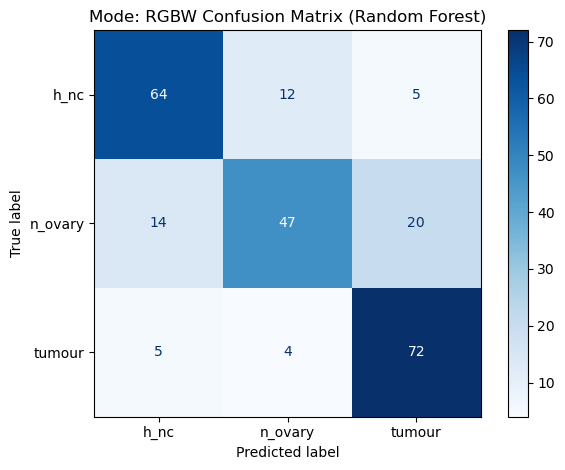

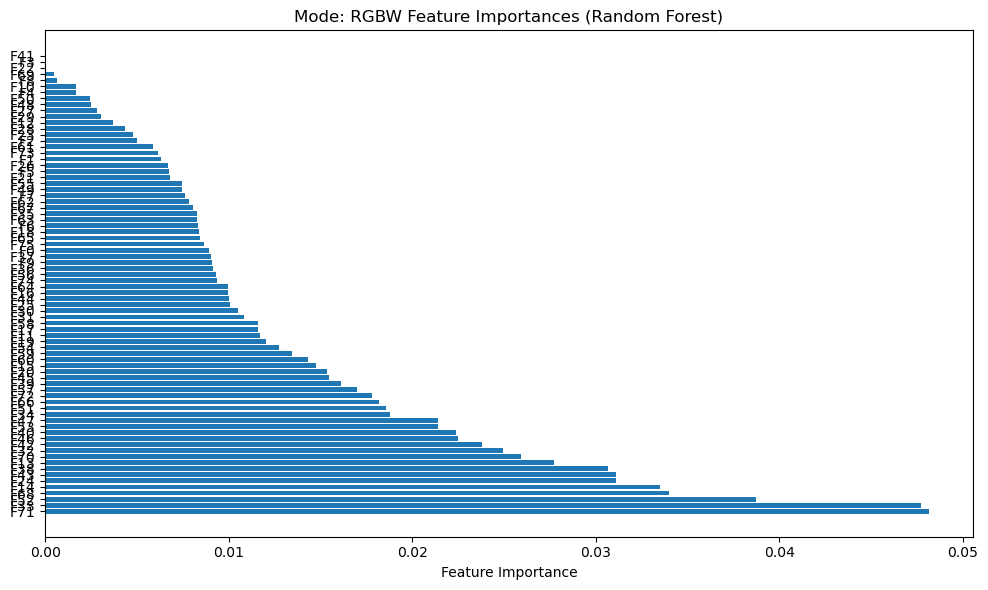

💾 Model, scaler, and label encoder saved to: H:\ML_MSI\ROI_based\RF_model


In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Feature Aggregation -------------------
def extract_combined_features(root_folder, coco_json_path, mode="RGBW"):
    all_modes = {
        "RGBW": ["r_", "g_", "b_", "w_"],
        "RGB": ["r_", "g_", "b_"],
        "W": ["w_"]
    }
    image_types = all_modes[mode]
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

# ------------------- Classifier -------------------
def train_with_random_forest(features, labels, title="Multichannel RGBW"):
    print(f"📊 {title} | Encoding + Scaling + SMOTE...")

    le = LabelEncoder()
    y = le.fit_transform(labels)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"🔢 After SMOTE: {np.bincount(y_resampled)}")

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    preds_all = []
    truths_all = []

    # ✅ Define classifier before training
    clf = RandomForestClassifier(n_estimators=200, random_state=42)

    for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

        # ✅ Train the model
        clf.fit(X_train, y_train)

        preds = clf.predict(X_test)
        preds_all.extend(preds)
        truths_all.extend(y_test)

    print(f"\n✅ Final Classification Report ({title} - Random Forest):")
    print(classification_report(truths_all, preds_all, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"{title} Confusion Matrix (Random Forest)")
    plt.tight_layout()
    plt.show()

    # Feature importance
    plt.figure(figsize=(10, 6))
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = [f"F{i}" for i in range(X.shape[1])]
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title(f"{title} Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.show()

    # ✅ Save model after training is complete
    import joblib
    model_save_dir = r"H:\ML_MSI\ROI_based\RF_model"
    os.makedirs(model_save_dir, exist_ok=True)
    joblib.dump(clf, os.path.join(model_save_dir, "random_forest_model.pkl"))
    joblib.dump(scaler, os.path.join(model_save_dir, "scaler.pkl"))
    joblib.dump(le, os.path.join(model_save_dir, "label_encoder.pkl"))
    print(f"💾 Model, scaler, and label encoder saved to: {model_save_dir}")

# ------------------- Entry Point -------------------
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\ML_MSI\ROI_based\vipul_annotation_1\annotation_27_05_25_vipul_3.json"

    for mode in ["RGBW"]:
        print(f"\n🔍 Extracting features for mode: {mode}...")
        X_all, y_all = extract_combined_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH, mode=mode)

        if not X_all:
            print(f"❌ No features found for {mode} mode.")
        else:
            train_with_random_forest(X_all, y_all, title=f"Mode: {mode}")


# VAlidation of the random forest model

In [4]:
import os
import json
import joblib
import numpy as np
from PIL import Image, ImageDraw
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

# ---------------- JSON Parsing ----------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        fname = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name[ann['category_id']]
        file_to_annotations[fname].append(ann)
    return file_to_annotations

# ---------------- Feature Extraction ----------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch = gray[:min(64, gray.shape[0]), :min(64, gray.shape[1])]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat), "Median": np.median(flat), "Std": np.std(flat),
        "Min": np.min(flat), "Max": np.max(flat), "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat), "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

def validate_model(model_dir, root_folder, json_path, mode="RGBW"):
    print("🔁 Loading saved model...")
    clf = joblib.load(os.path.join(model_dir, "random_forest_model.pkl"))
    scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))
    le = joblib.load(os.path.join(model_dir, "label_encoder.pkl"))

    print("🧬 Extracting features for validation...")
    X_val, y_val = extract_features(root_folder, json_path, mode)
    if not X_val:
        print("❌ No features found for validation!")
        return

    X_val_scaled = scaler.transform(X_val)
    y_val_encoded = le.transform(y_val)

    # 🔮 Predictions
    y_pred = clf.predict(X_val_scaled)
    y_proba = clf.predict_proba(X_val_scaled)  # Needed for ROC/AUC

    # 📝 Classification report
    print("\n✅ Classification Report:")
    print(classification_report(y_val_encoded, y_pred, target_names=le.classes_))

    # ✅ Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_val_encoded, y_pred, display_labels=le.classes_, cmap='Blues')
    plt.title("Confusion Matrix - Validation")
    plt.tight_layout()
    plt.show()

    # ✅ ROC & AUC Curve
    y_val_bin = label_binarize(y_val_encoded, classes=range(len(le.classes_)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 🎯 Plot ROC curves
    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(le.classes_):
        plt.plot(fpr[i], tpr[i], label=f"{class_name} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multi-class')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

# ---------------- Entry ----------------
if __name__ == "__main__":
    MODEL_DIR = r"H:\ML_MSI\ROI_based\RF_model"
    ROOT_FOLDER = r"H:\ML_MSI\ROI_based\val_data"
    COCO_JSON = r"H:\ML_MSI\ROI_based\vipul_annotation_1\annotation_27_05_25_vipul_3.json"
    validate_model(MODEL_DIR, ROOT_FOLDER, COCO_JSON, mode="RGBW")


🔁 Loading saved model...
🧬 Extracting features for validation...
✅ Model: Extracted 0 samples
❌ No features found for validation!



🔍 Extracting validation features for mode: RGBW...
📊 RGBW | Validating on 16 regions...

✅ Classification Report on Validation Set:
              precision    recall  f1-score   support

        h_nc       1.00      0.71      0.83         7
     n_ovary       0.83      0.83      0.83         6
      tumour       0.60      1.00      0.75         3

    accuracy                           0.81        16
   macro avg       0.81      0.85      0.81        16
weighted avg       0.86      0.81      0.82        16



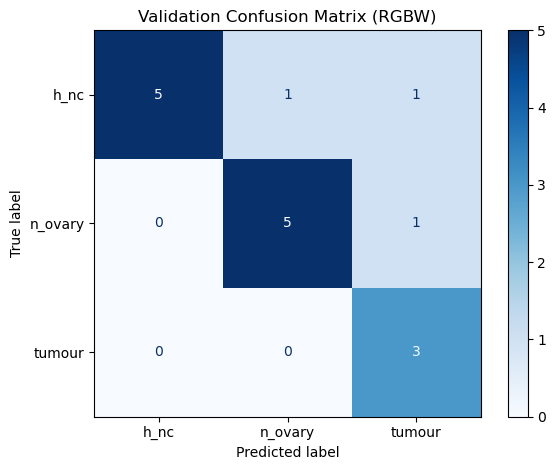

In [1]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Validation Pipeline -------------------
def validate_random_forest_model_with_subfolders(image_root, json_path, model_dir, mode="RGBW"):
    print(f"\n🔍 Extracting validation features for mode: {mode}...")

    all_modes = {
        "RGBW": ["r_", "g_", "b_", "w_"],
        "RGB": ["r_", "g_", "b_"],
        "W": ["w_"]
    }
    image_types = all_modes[mode]
    categories = ["n_ovary", "h_nc", "tumour"]

    coco_data = load_coco_json(json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(image_root):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):
                    all_features.append(feat_list)
                    all_labels.append(cat)

    if not all_features:
        print(f"❌ No features found in test set.")
        return

    print(f"📊 {mode} | Validating on {len(all_features)} regions...")

    # Load model, scaler, and label encoder
    clf = joblib.load(os.path.join(model_dir, "random_forest_model.pkl"))
    scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))
    le = joblib.load(os.path.join(model_dir, "label_encoder.pkl"))

    # Preprocess features
    X = scaler.transform(all_features)
    y_true = le.transform(all_labels)

    # Predict
    y_pred = clf.predict(X)

    # Report results
    print("\n✅ Classification Report on Validation Set:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"Validation Confusion Matrix ({mode})")
    plt.tight_layout()
    plt.show()

# ------------------- Entry Point -------------------
if __name__ == "__main__":
    TEST_FOLDER = r"H:\ML_MSI\ROI_based\val_data"
    TEST_JSON = r"H:\ML_MSI\ROI_based\val_data\annotation_27_05_25_vipul_3.json"
    MODEL_DIR = r"H:\ML_MSI\ROI_based\RF_model"

    validate_random_forest_model_with_subfolders(TEST_FOLDER, TEST_JSON, MODEL_DIR, mode="RGBW")


#SVM

✅ RGBW: Extracted 77 samples

📊 Classification Report (RGBW - Random Forest):
              precision    recall  f1-score   support

        h_nc       0.89      0.85      0.87        66
     n_ovary       0.86      0.76      0.81        66
      tumour       0.79      0.92      0.85        66

    accuracy                           0.84       198
   macro avg       0.85      0.84      0.84       198
weighted avg       0.85      0.84      0.84       198



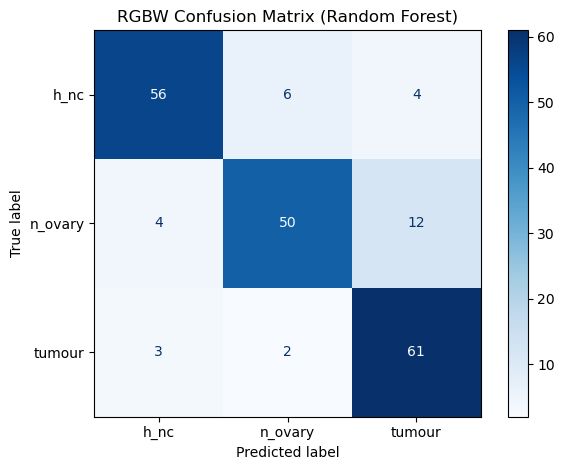

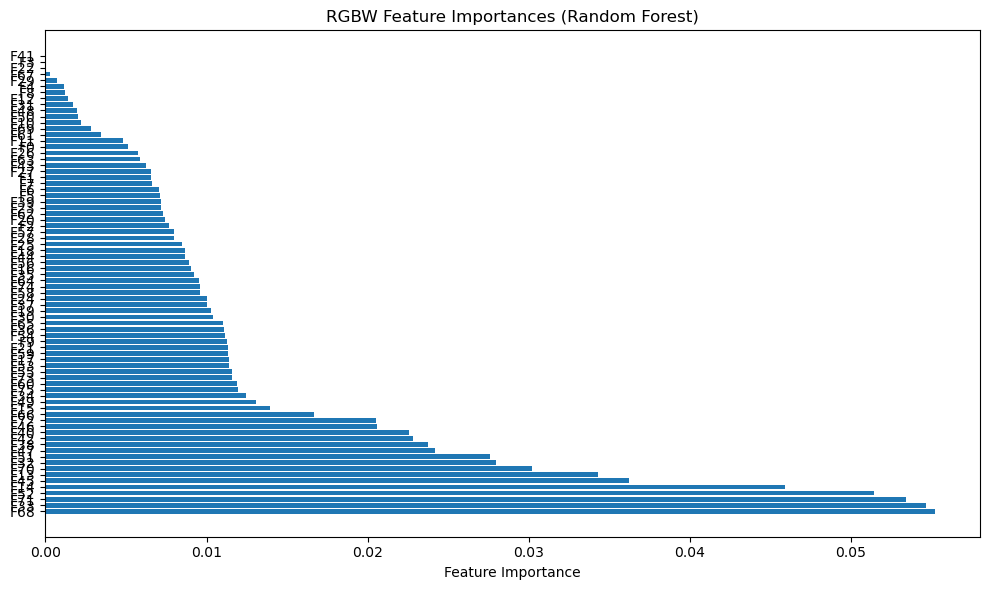


📊 Classification Report (RGBW - SVM):
              precision    recall  f1-score   support

        h_nc       0.75      0.62      0.68        66
     n_ovary       0.70      0.58      0.63        66
      tumour       0.65      0.88      0.75        66

    accuracy                           0.69       198
   macro avg       0.70      0.69      0.69       198
weighted avg       0.70      0.69      0.69       198



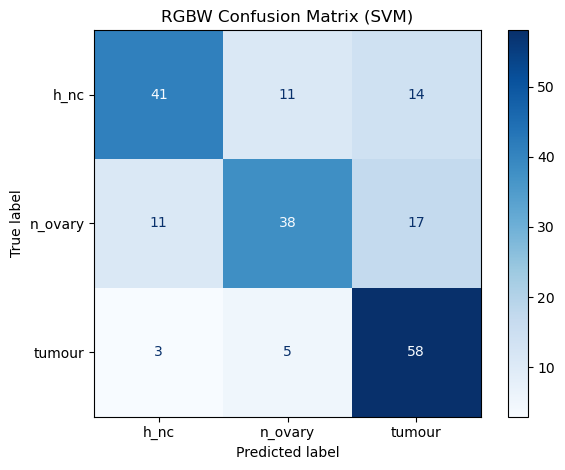

c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:51:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:51:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:51:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Classification Report (RGBW - XGBoost):
              precision    recall  f1-score   support

        h_nc       0.82      0.85      0.84        66
     n_ovary       0.79      0.67      0.72        66
      tumour       0.78      0.88      0.83        66

    accuracy                           0.80       198
   macro avg       0.80      0.80      0.80       198
weighted avg       0.80      0.80      0.80       198



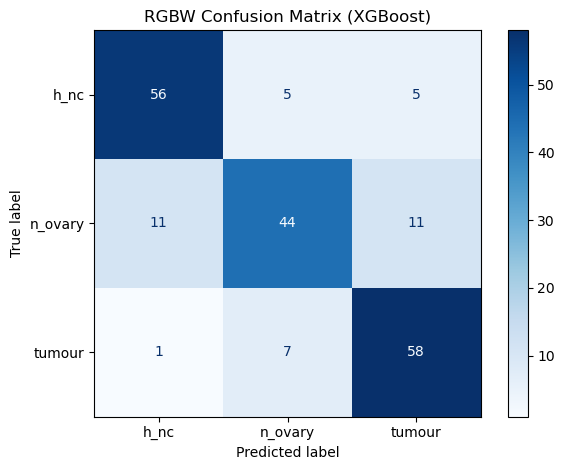

✅ RGB: Extracted 77 samples

📊 Classification Report (RGB - Random Forest):
              precision    recall  f1-score   support

        h_nc       0.82      0.89      0.86        66
     n_ovary       0.84      0.71      0.77        66
      tumour       0.84      0.89      0.87        66

    accuracy                           0.83       198
   macro avg       0.83      0.83      0.83       198
weighted avg       0.83      0.83      0.83       198



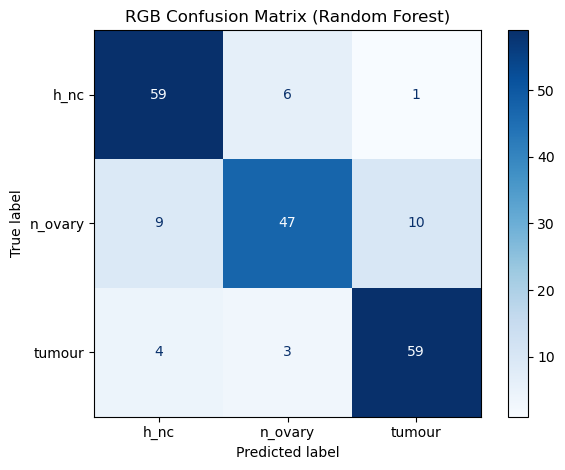

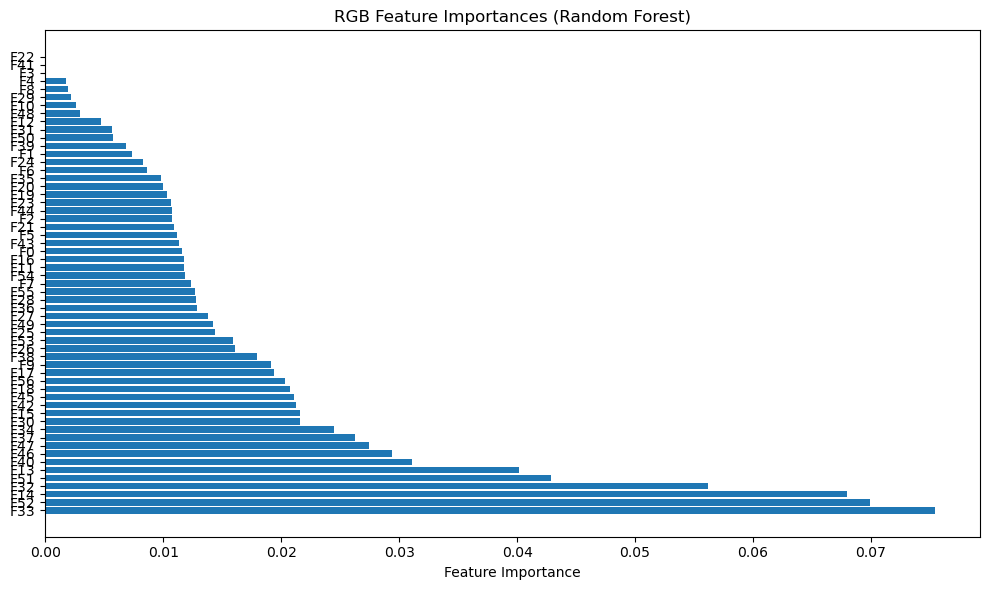


📊 Classification Report (RGB - SVM):
              precision    recall  f1-score   support

        h_nc       0.64      0.55      0.59        66
     n_ovary       0.66      0.53      0.59        66
      tumour       0.64      0.86      0.74        66

    accuracy                           0.65       198
   macro avg       0.65      0.65      0.64       198
weighted avg       0.65      0.65      0.64       198



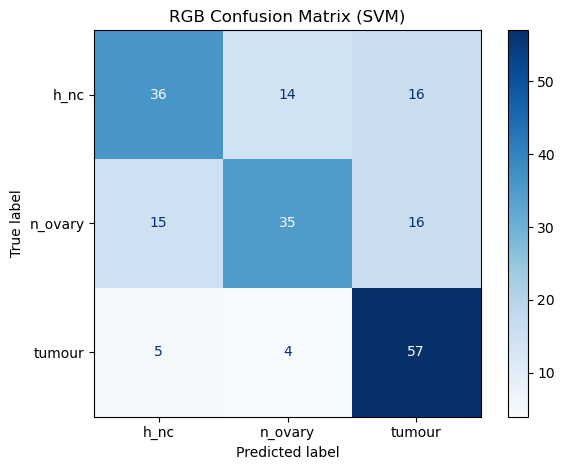

c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:52:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:52:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:52:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Classification Report (RGB - XGBoost):
              precision    recall  f1-score   support

        h_nc       0.78      0.82      0.80        66
     n_ovary       0.81      0.70      0.75        66
      tumour       0.82      0.89      0.86        66

    accuracy                           0.80       198
   macro avg       0.80      0.80      0.80       198
weighted avg       0.80      0.80      0.80       198



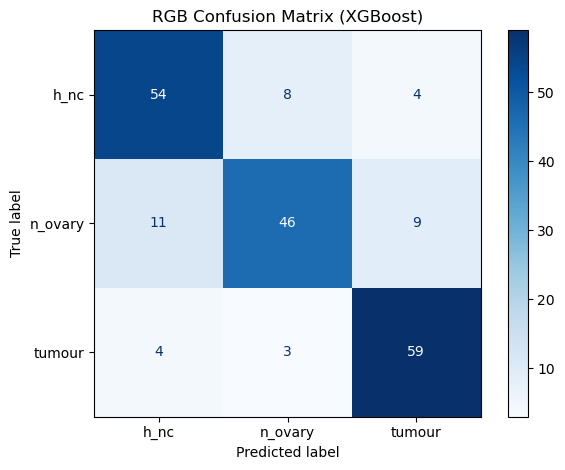

✅ White Light: Extracted 77 samples

📊 Classification Report (White Light - Random Forest):
              precision    recall  f1-score   support

        h_nc       0.83      0.80      0.82        66
     n_ovary       0.72      0.64      0.68        66
      tumour       0.78      0.89      0.83        66

    accuracy                           0.78       198
   macro avg       0.78      0.78      0.77       198
weighted avg       0.78      0.78      0.77       198



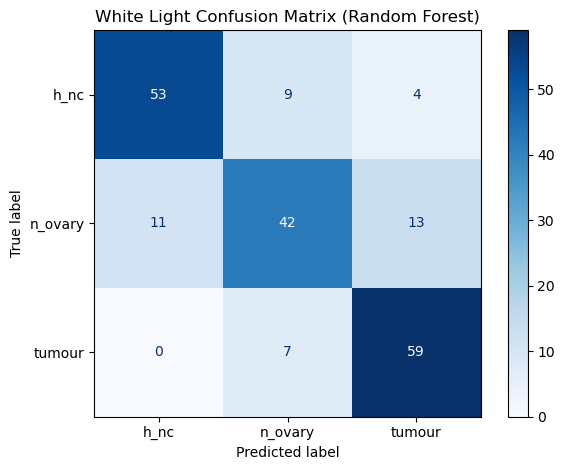

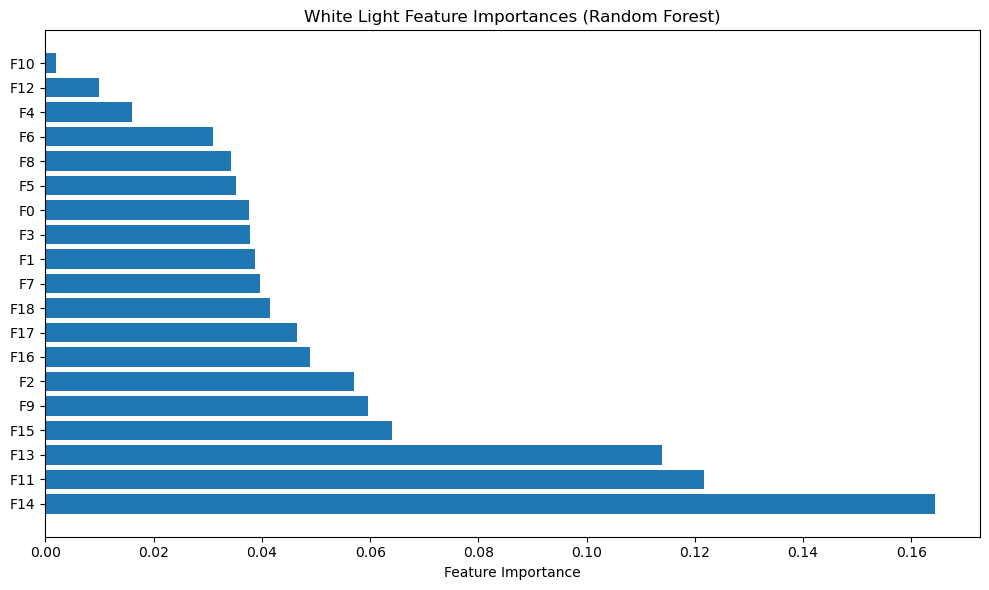


📊 Classification Report (White Light - SVM):
              precision    recall  f1-score   support

        h_nc       0.82      0.74      0.78        66
     n_ovary       0.73      0.56      0.63        66
      tumour       0.69      0.91      0.78        66

    accuracy                           0.74       198
   macro avg       0.74      0.74      0.73       198
weighted avg       0.74      0.74      0.73       198



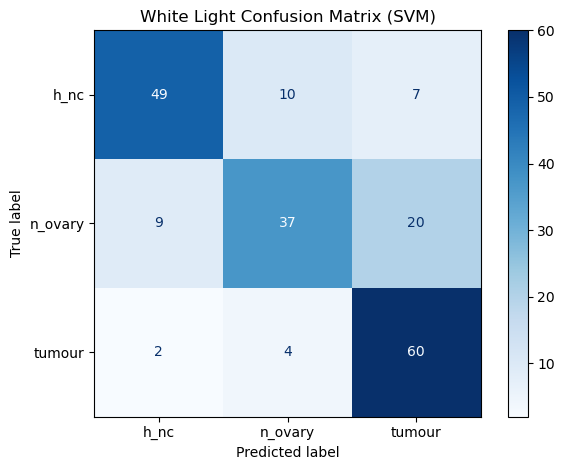

c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:52:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:52:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:52:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Classification Report (White Light - XGBoost):
              precision    recall  f1-score   support

        h_nc       0.81      0.85      0.83        66
     n_ovary       0.73      0.62      0.67        66
      tumour       0.78      0.86      0.82        66

    accuracy                           0.78       198
   macro avg       0.77      0.78      0.77       198
weighted avg       0.77      0.78      0.77       198



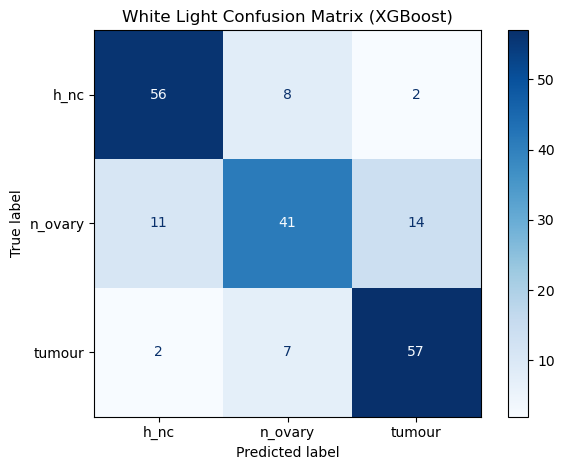

In [35]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Feature Aggregation -------------------
def extract_features(root_folder, coco_json_path, image_types, title="Model"):
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape
                    all_features.append(feat_list)
                    all_labels.append(cat)

    print(f"✅ {title}: Extracted {len(all_features)} samples")
    return all_features, all_labels

# ------------------- Classifier -------------------
def train_and_evaluate(X, y, title="Model"):
    import numpy as np  # in case not already imported

    X = np.array(X)  # ✅ FIX: convert list to array
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y_enc)

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

    models = {
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "SVM": SVC(kernel='rbf', C=1, probability=True, random_state=42)
    }

    for name, model in models.items():
        preds_all, truths_all = [], []
        for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
            X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
            y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            preds_all.extend(preds)
            truths_all.extend(y_test)

        print(f"\n📊 Classification Report ({title} - {name}):")
        print(classification_report(truths_all, preds_all, target_names=le.classes_))

        ConfusionMatrixDisplay.from_predictions(
            truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
        )

def train_and_evaluate(X, y, title="Model"):
    import numpy as np

    X = np.array(X)  # Convert list to array
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y_enc)

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

    models = {
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "SVM": SVC(kernel='rbf', C=1, probability=True, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    }

    for name, model in models.items():
        preds_all, truths_all = [], []
        for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
            X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
            y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            preds_all.extend(preds)
            truths_all.extend(y_test)

        print(f"\n📊 Classification Report ({title} - {name}):")
        print(classification_report(truths_all, preds_all, target_names=le.classes_))

        ConfusionMatrixDisplay.from_predictions(
            truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
        )
        plt.title(f"{title} Confusion Matrix ({name})")
        plt.tight_layout()
        plt.show()

        if name == "Random Forest":
            plt.figure(figsize=(10, 6))
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            feature_names = [f"F{i}" for i in range(X.shape[1])]
            plt.barh(range(len(indices)), importances[indices])
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.xlabel("Feature Importance")
            plt.title(f"{title} Feature Importances ({name})")
            plt.tight_layout()
            plt.show()

# ------------------- Entry Point -------------------
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\Granulosa_data_1\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"

    # Multichannel RGBW
    X_rgbw, y_rgbw = extract_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH, ["r_", "g_", "b_", "w_"], title="RGBW")
    if X_rgbw:
        train_and_evaluate(X_rgbw, y_rgbw, title="RGBW")

    # RGB only
    X_rgb, y_rgb = extract_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH, ["r_", "g_", "b_"], title="RGB")
    if X_rgb:
        train_and_evaluate(X_rgb, y_rgb, title="RGB")

    # White only
    X_w, y_w = extract_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH, ["w_"], title="White Light")
    if X_w:
        train_and_evaluate(X_w, y_w, title="White Light")



✅ RGBW: Extracted 61 samples

📊 Classification Report (RGBW - Random Forest):
              precision    recall  f1-score   support

        h_nc       0.79      0.78      0.79        54
     n_ovary       0.77      0.61      0.68        54
      tumour       0.74      0.91      0.82        54

    accuracy                           0.77       162
   macro avg       0.77      0.77      0.76       162
weighted avg       0.77      0.77      0.76       162



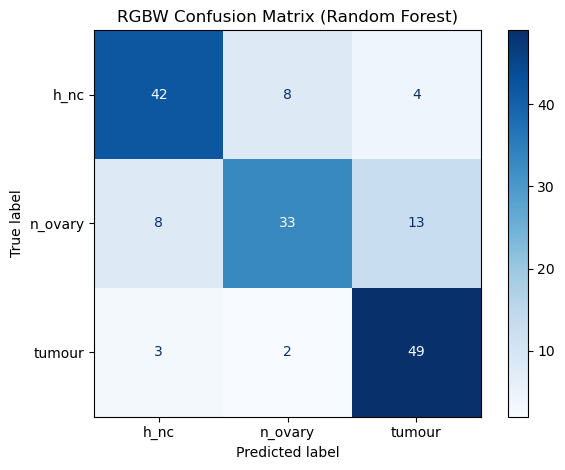

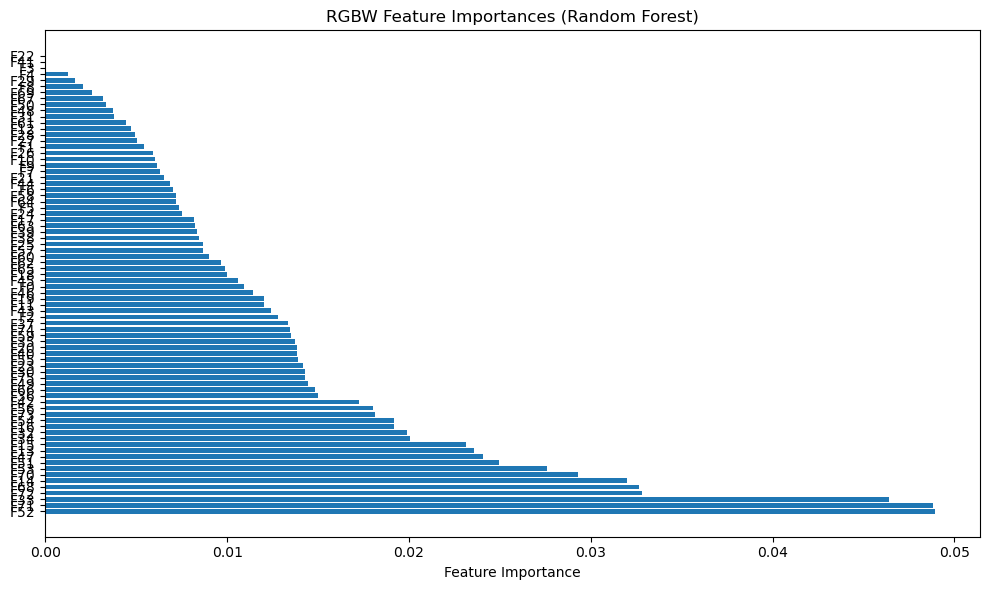


📊 Classification Report (RGBW - SVM):
              precision    recall  f1-score   support

        h_nc       0.77      0.74      0.75        54
     n_ovary       0.75      0.56      0.64        54
      tumour       0.67      0.87      0.76        54

    accuracy                           0.72       162
   macro avg       0.73      0.72      0.72       162
weighted avg       0.73      0.72      0.72       162



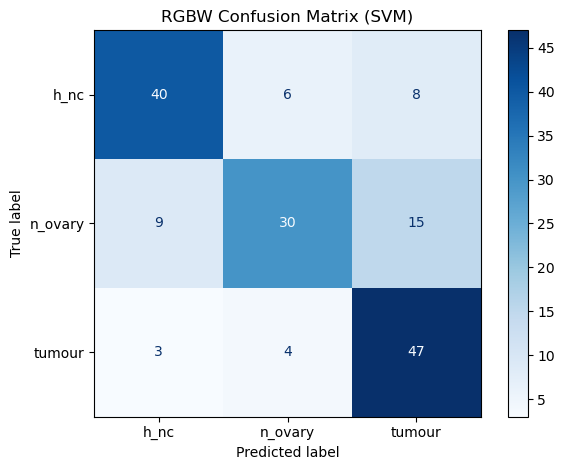

c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:00:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:00:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Classification Report (RGBW - XGBoost):
              precision    recall  f1-score   support

        h_nc       0.79      0.78      0.79        54
     n_ovary       0.63      0.57      0.60        54
      tumour       0.72      0.80      0.75        54

    accuracy                           0.72       162
   macro avg       0.71      0.72      0.71       162
weighted avg       0.71      0.72      0.71       162



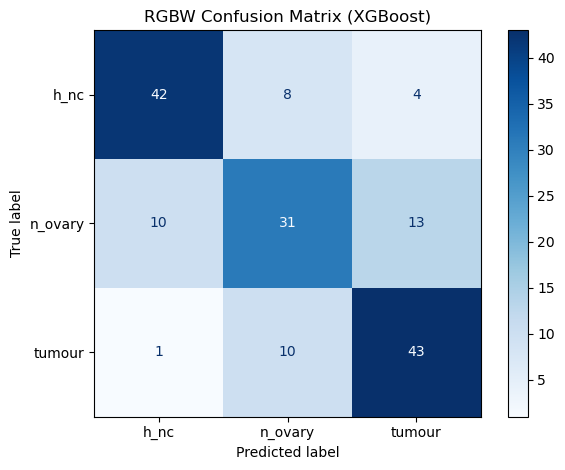


✅ RGB: Extracted 61 samples

📊 Classification Report (RGB - Random Forest):
              precision    recall  f1-score   support

        h_nc       0.77      0.81      0.79        54
     n_ovary       0.81      0.63      0.71        54
      tumour       0.75      0.87      0.80        54

    accuracy                           0.77       162
   macro avg       0.78      0.77      0.77       162
weighted avg       0.78      0.77      0.77       162



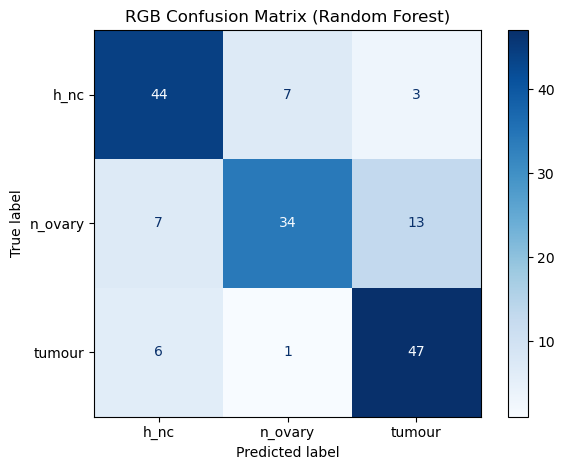

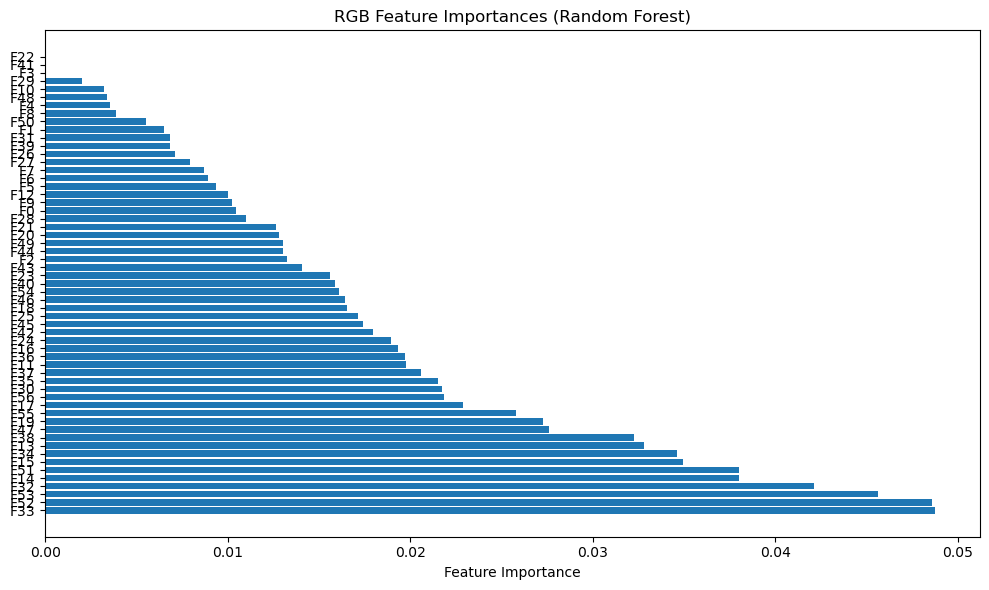


📊 Classification Report (RGB - SVM):
              precision    recall  f1-score   support

        h_nc       0.74      0.80      0.77        54
     n_ovary       0.74      0.52      0.61        54
      tumour       0.70      0.85      0.77        54

    accuracy                           0.72       162
   macro avg       0.73      0.72      0.71       162
weighted avg       0.73      0.72      0.71       162



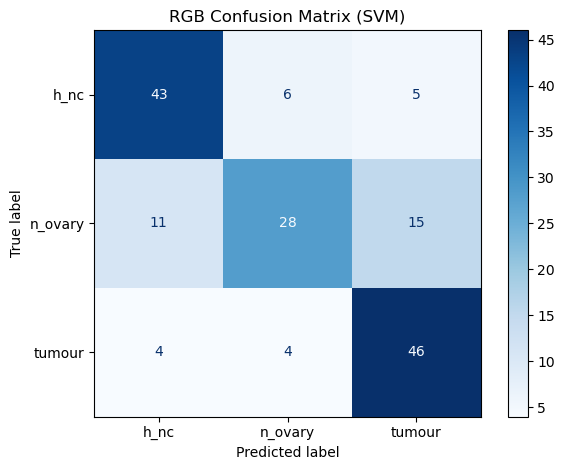

c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:01:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:01:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Classification Report (RGB - XGBoost):
              precision    recall  f1-score   support

        h_nc       0.75      0.72      0.74        54
     n_ovary       0.69      0.67      0.68        54
      tumour       0.71      0.76      0.73        54

    accuracy                           0.72       162
   macro avg       0.72      0.72      0.72       162
weighted avg       0.72      0.72      0.72       162



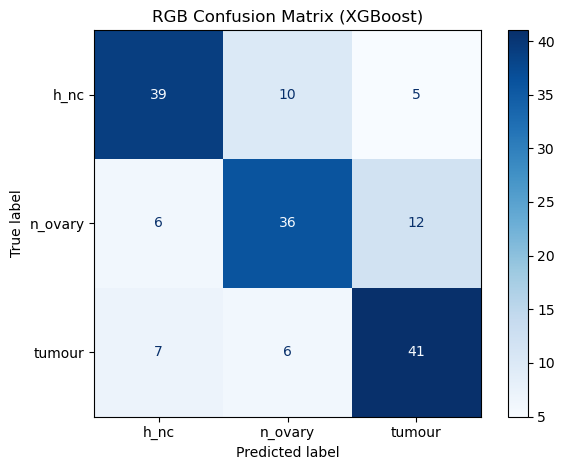


✅ White Light: Extracted 61 samples

📊 Classification Report (White Light - Random Forest):
              precision    recall  f1-score   support

        h_nc       0.84      0.89      0.86        54
     n_ovary       0.77      0.56      0.65        54
      tumour       0.73      0.89      0.80        54

    accuracy                           0.78       162
   macro avg       0.78      0.78      0.77       162
weighted avg       0.78      0.78      0.77       162



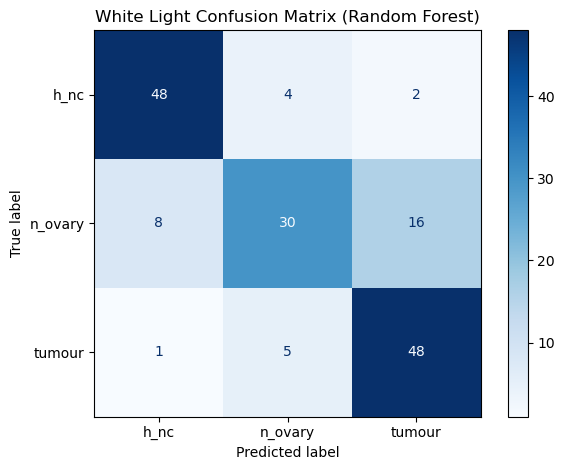

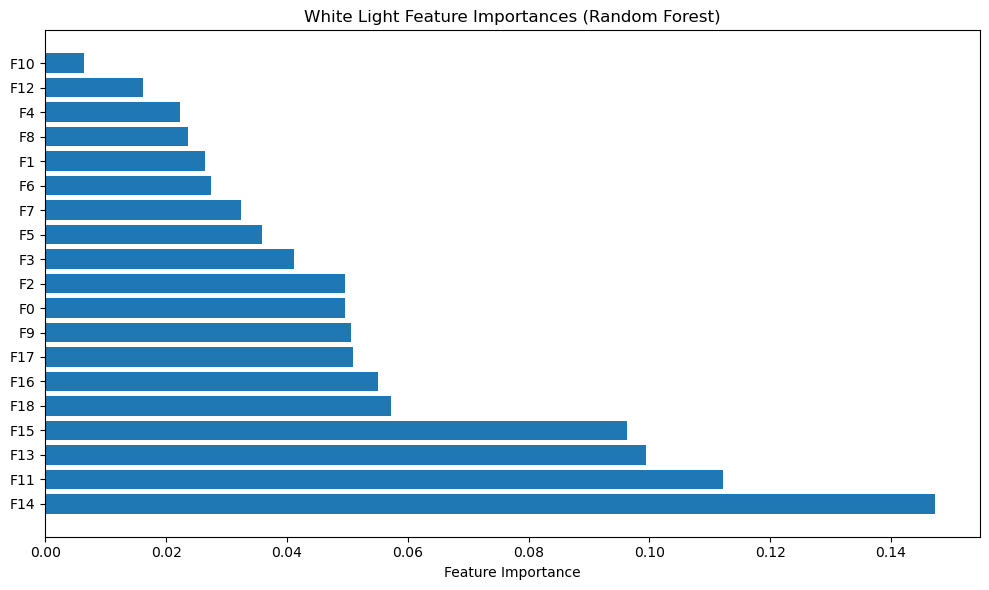


📊 Classification Report (White Light - SVM):
              precision    recall  f1-score   support

        h_nc       0.76      0.70      0.73        54
     n_ovary       0.71      0.50      0.59        54
      tumour       0.65      0.89      0.75        54

    accuracy                           0.70       162
   macro avg       0.71      0.70      0.69       162
weighted avg       0.71      0.70      0.69       162



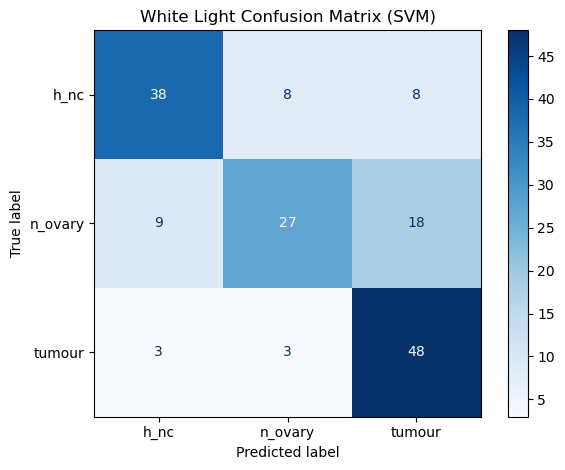

c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:01:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:01:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Classification Report (White Light - XGBoost):
              precision    recall  f1-score   support

        h_nc       0.77      0.80      0.78        54
     n_ovary       0.70      0.56      0.62        54
      tumour       0.73      0.85      0.79        54

    accuracy                           0.73       162
   macro avg       0.73      0.73      0.73       162
weighted avg       0.73      0.73      0.73       162



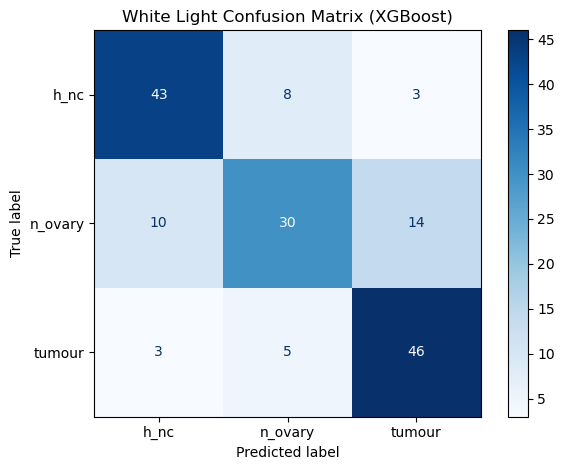

In [8]:
import os
import json
import numpy as np
import joblib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from collections import defaultdict
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

def extract_features(root_folder, coco_json_path, image_types, title="Model"):
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):
                    all_features.append(feat_list)
                    all_labels.append(cat)

    print(f"\n✅ {title}: Extracted {len(all_features)} samples")
    return all_features, all_labels

def train_and_evaluate(X, y, title="Model", save_dir=None):
    X = np.array(X)
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y_enc)

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

    models = {
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "SVM": SVC(kernel='rbf', C=1, probability=True, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    }

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        joblib.dump(le, os.path.join(save_dir, "label_encoder.pkl"))
        joblib.dump(scaler, os.path.join(save_dir, "scaler.pkl"))

    for name, model in models.items():
        preds_all, truths_all = [], []
        for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
            X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
            y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            preds_all.extend(preds)
            truths_all.extend(y_test)

        print(f"\n📊 Classification Report ({title} - {name}):")
        print(classification_report(truths_all, preds_all, target_names=le.classes_))

        ConfusionMatrixDisplay.from_predictions(
            truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
        )
        plt.title(f"{title} Confusion Matrix ({name})")
        plt.tight_layout()
        plt.show()

        if save_dir:
            model_name = name.lower().replace(" ", "_") + ".pkl"
            joblib.dump(model, os.path.join(save_dir, model_name))

        if name == "Random Forest":
            plt.figure(figsize=(10, 6))
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            feature_names = [f"F{i}" for i in range(X.shape[1])]
            plt.barh(range(len(indices)), importances[indices])
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.xlabel("Feature Importance")
            plt.title(f"{title} Feature Importances ({name})")
            plt.tight_layout()
            plt.show()


if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\\Granulosa_data_1\\vipul_annotation_1\\annotation_27_05_25_vipul_3.json"
    MODEL_SAVE_BASE = r"H:\\ML_MSI\\ROI_based\\models_saved_all"

    # RGBW
    X_rgbw, y_rgbw = extract_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH, ["r_", "g_", "b_", "w_"], title="RGBW")
    if X_rgbw:
        train_and_evaluate(X_rgbw, y_rgbw, title="RGBW", save_dir=os.path.join(MODEL_SAVE_BASE, "RGBW"))

    # RGB
    X_rgb, y_rgb = extract_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH, ["r_", "g_", "b_"], title="RGB")
    if X_rgb:
        train_and_evaluate(X_rgb, y_rgb, title="RGB", save_dir=os.path.join(MODEL_SAVE_BASE, "RGB"))

    # White Light
    X_w, y_w = extract_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH, ["w_"], title="White Light")
    if X_w:
        train_and_evaluate(X_w, y_w, title="White Light", save_dir=os.path.join(MODEL_SAVE_BASE, "White_Light"))


validation of all models

In [15]:
import os

MODEL_DIR = r"H:\ML_MSI\ROI_based\models_saved_all"
print("Files in model directory:")
for f in os.listdir(MODEL_DIR):
    print(f)


Files in model directory:
RGB
RGBW
White_Light


✅ RGBW: Extracted 77 samples

🔍 Training RandomForest for RGBW


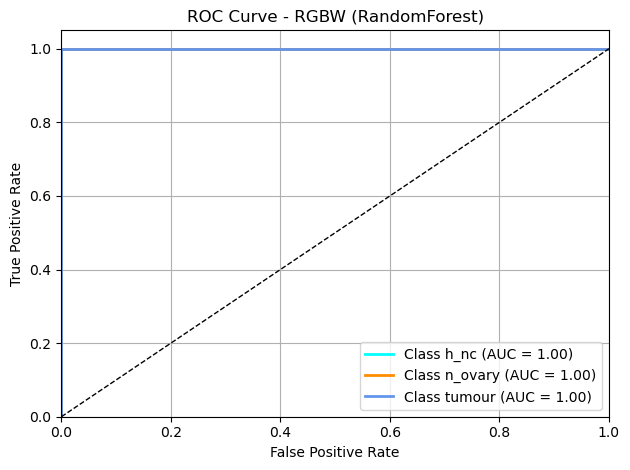


🔍 Training SVM for RGBW


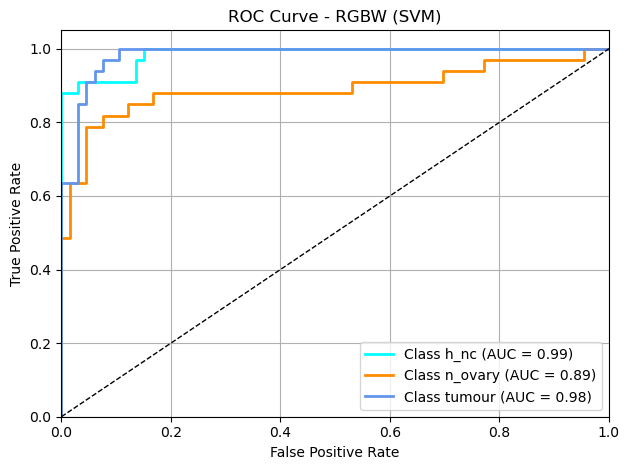


🔍 Training XGBoost for RGBW


c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:07:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


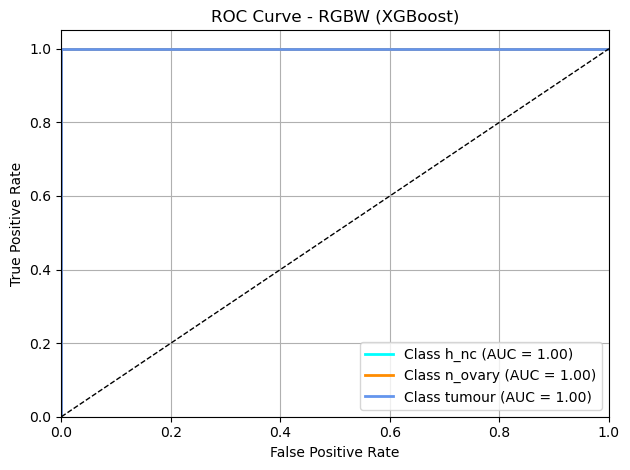

✅ RGB: Extracted 77 samples

🔍 Training RandomForest for RGB


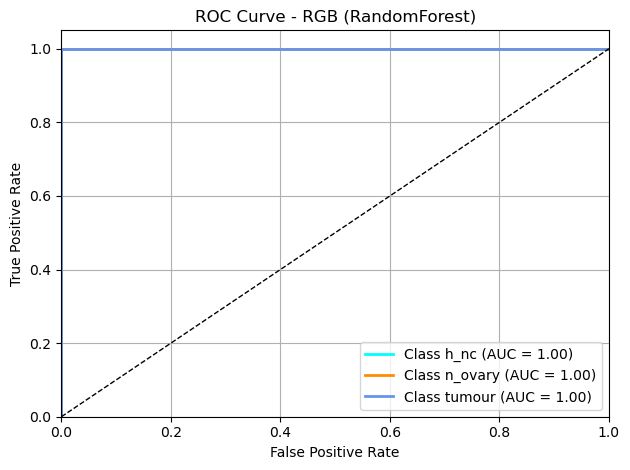


🔍 Training SVM for RGB


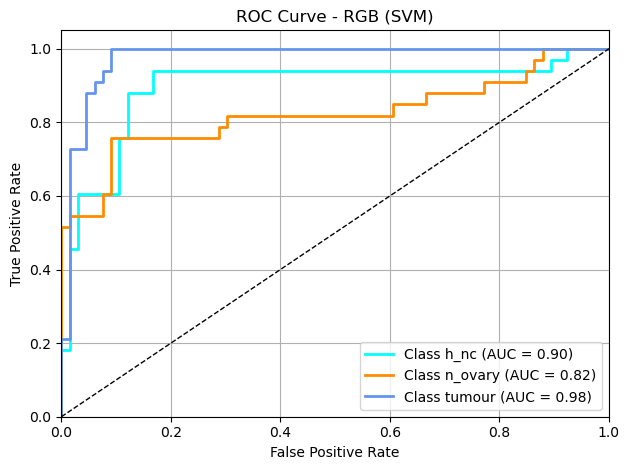


🔍 Training XGBoost for RGB


c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


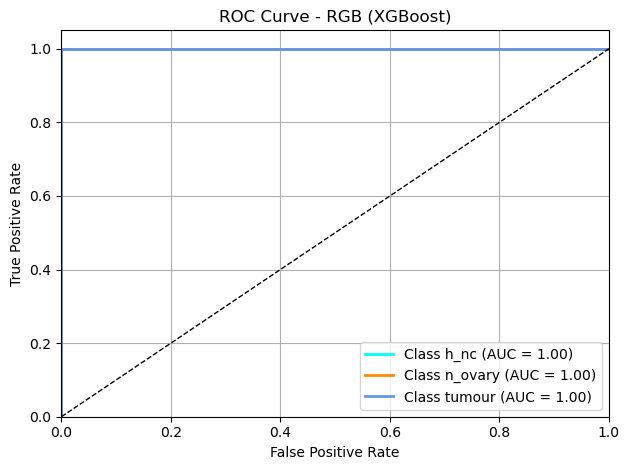

✅ White Light: Extracted 77 samples

🔍 Training RandomForest for White Light


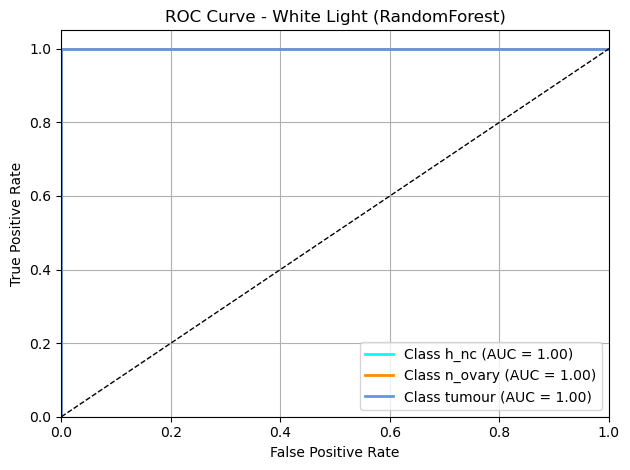


🔍 Training SVM for White Light


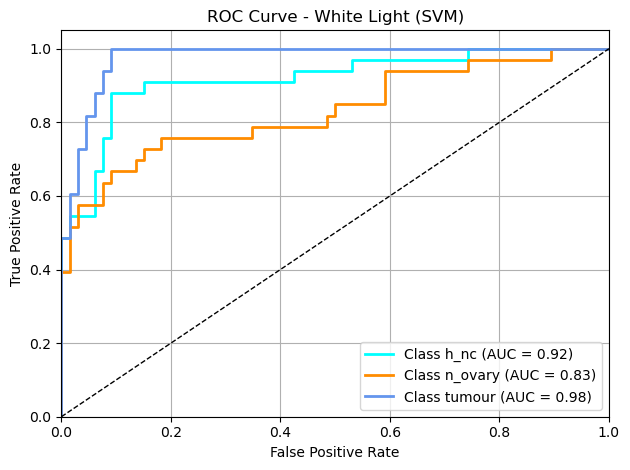


🔍 Training XGBoost for White Light


c:\Users\vipul\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


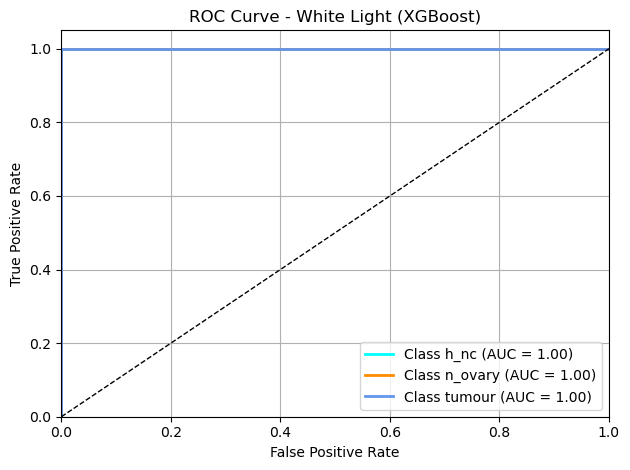

In [2]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Feature Aggregation -------------------
def extract_features(root_folder, coco_json_path, image_types, title="Model"):
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape
                    all_features.append(feat_list)
                    all_labels.append(cat)

    print(f"✅ {title}: Extracted {len(all_features)} samples")
    return all_features, all_labels

# ------------------- Classifier -------------------
def train_and_evaluate(X, y, title="Model"):
    import numpy as np  # in case not already imported

    X = np.array(X)  # ✅ FIX: convert list to array
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y_enc)

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

    models = {
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "SVM": SVC(kernel='rbf', C=1, probability=True, random_state=42)
    }

    for name, model in models.items():
        preds_all, truths_all = [], []
        for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
            X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
            y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            preds_all.extend(preds)
            truths_all.extend(y_test)

        print(f"\n📊 Classification Report ({title} - {name}):")
        print(classification_report(truths_all, preds_all, target_names=le.classes_))

        ConfusionMatrixDisplay.from_predictions(
            truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
        )

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

def train_and_evaluate(X, y, title="Model"):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_binarized = label_binarize(y_encoded, classes=np.unique(y_encoded))

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y_encoded)
    y_res_bin = label_binarize(y_res, classes=np.unique(y_encoded))

    classifiers = {
        "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
        "SVM": SVC(kernel='linear', probability=True, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    }

    for model_name, model in classifiers.items():
        print(f"\n🔍 Training {model_name} for {title}")
        ovr = OneVsRestClassifier(model)
        ovr.fit(X_res, y_res_bin)
        y_score = ovr.predict_proba(X_res)

        # ROC Curve
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_res_bin.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_res_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot ROC Curve
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(y_res_bin.shape[1]), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:0.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {title} ({model_name})')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# ------------------- Entry Point -------------------
if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\Granulosa_data_1\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"

    # Multichannel RGBW
    X_rgbw, y_rgbw = extract_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH, ["r_", "g_", "b_", "w_"], title="RGBW")
    if X_rgbw:
        train_and_evaluate(X_rgbw, y_rgbw, title="RGBW")

    # RGB only
    X_rgb, y_rgb = extract_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH, ["r_", "g_", "b_"], title="RGB")
    if X_rgb:
        train_and_evaluate(X_rgb, y_rgb, title="RGB")

    # White only
    X_w, y_w = extract_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH, ["w_"], title="White Light")
    if X_w:
        train_and_evaluate(X_w, y_w, title="White Light")
